<a href="https://colab.research.google.com/github/i-m-sonu/algomate/blob/colab/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
moveing average stratergy

Initial Balance: ₹10000
Final Balance: ₹15279.83
Total Profit/Loss: ₹5279.83
Number of Trades Executed: 10
Total Profit/Loss from all trades: ₹5279.83

Trade Log:
    Sr. No.          Trade Time           Action    Price  Profit/Loss
0         1 2015-01-09 09:59:00         Buy Call  8296.05     0.000000
1         1 2015-01-09 10:10:00        Sell Call  8292.60  -363.081939
2         1 2015-01-09 10:10:00          Buy Put  8292.60     0.000000
3         2 2015-01-09 10:18:00         Buy Call  8295.60     0.000000
4         2 2015-01-09 10:35:00        Sell Call  8301.55   576.909642
5         2 2015-01-09 10:35:00          Buy Put  8301.55     0.000000
6         3 2015-01-09 10:54:00         Buy Call  8296.10     0.000000
7         3 2015-01-09 11:07:00        Sell Call  8294.15  -213.083548
8         3 2015-01-09 11:07:00          Buy Put  8294.15     0.000000
9         4 2015-01-09 11:44:00         Buy Call  8264.95     0.000000
10        4 2015-01-09 11:53:00        Sell Call  8265.9

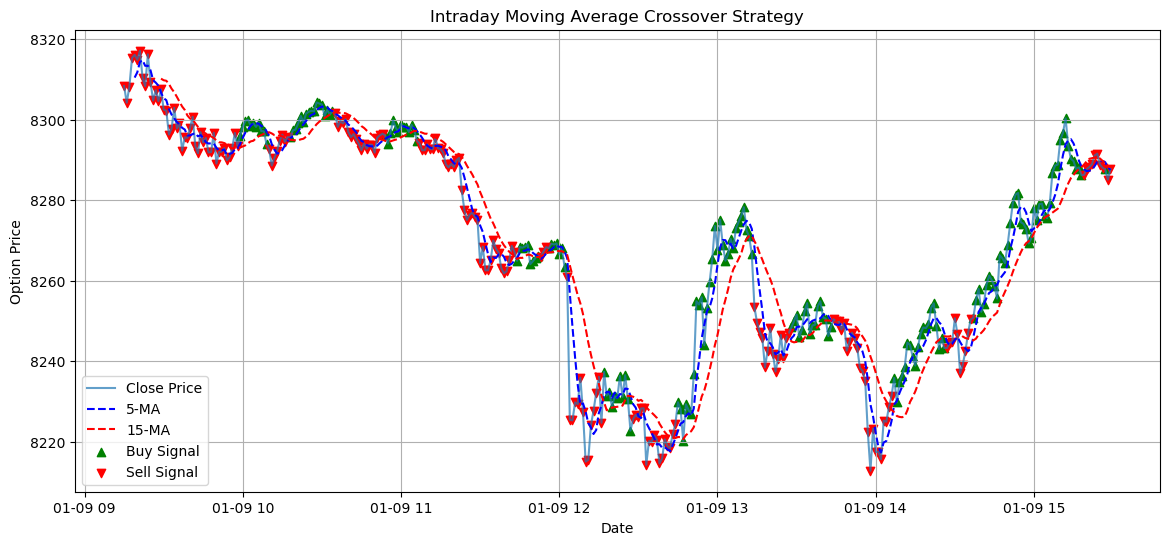

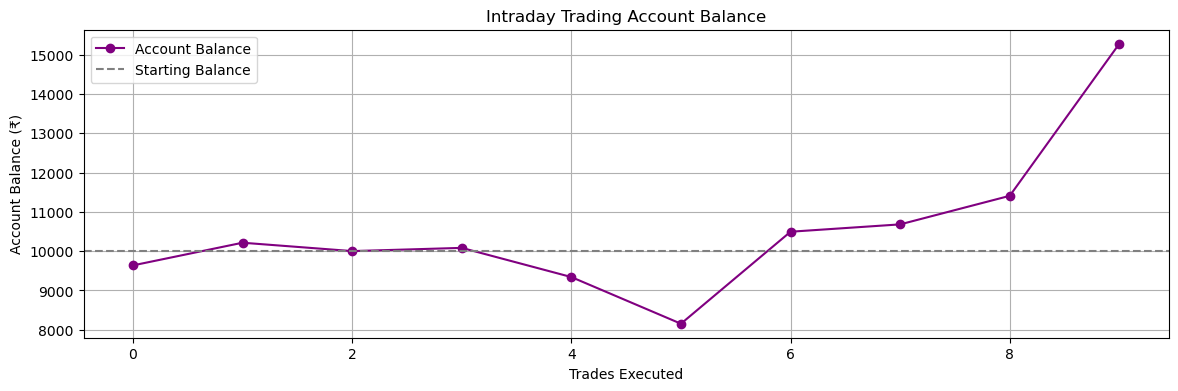

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load NSE intraday data
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Calculate Moving Averages (Short-term & Long-term)
df["5_MA"] = df["close"].rolling(window=5).mean()
df["15_MA"] = df["close"].rolling(window=15).mean()

# Generate Buy (Call) and Sell (Put) Signals
df["Signal"] = np.where(df["5_MA"] > df["15_MA"], 1, -1)  # 1 = Buy Call, -1 = Buy Put

# Set Market Open and Close Times
market_open = "09:15:00"
market_close = "15:15:00"

# Track positions, profit/loss
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
balance_over_time = []

position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

# Track the number of trades
num_trades = 0
total_profit_loss = 0

# Iterate through data to execute intraday strategy
for i in range(1, len(df)):
    curr_time = df["date"].iloc[i].time().strftime("%H:%M:%S")
    prev_signal = df["Signal"].iloc[i - 1]
    curr_signal = df["Signal"].iloc[i]
    close_price = df["close"].iloc[i]

    # Check if market is open
    if market_open <= curr_time <= market_close:
        # Entry Conditions
        if prev_signal != curr_signal:
            if curr_signal == 1:  # Buy Call
                position = "Call"
                entry_price = close_price
                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Buy Call", "Price": close_price})

            elif curr_signal == -1 and position == "Call":  # Sell Call, Buy Put
                profit = (close_price - entry_price) * 100  # Assuming 1 contract (100 shares)

                # Calculate Transaction Costs (Brokerage, GST, STT)
                brokerage = entry_price * brokerage_rate
                gst = brokerage * gst_rate
                stt = close_price * stt_rate

                # Total transaction cost
                total_cost = brokerage + gst + stt

                # Final Profit or Loss after deducting charges
                final_profit_loss = profit - total_cost
                balance += final_profit_loss
                total_profit_loss += final_profit_loss

                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Sell Call", "Price": close_price,
                                  "Profit/Loss": final_profit_loss})
                balance_over_time.append(balance)
                position = "Put"
                entry_price = close_price
                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Buy Put", "Price": close_price})

                num_trades += 1  # Increase trade count

            elif curr_signal == 1 and position == "Put":  # Sell Put, Buy Call
                profit = (entry_price - close_price) * 100

                # Calculate Transaction Costs (Brokerage, GST, STT)
                brokerage = entry_price * brokerage_rate
                gst = brokerage * gst_rate
                stt = close_price * stt_rate

                # Total transaction cost
                total_cost = brokerage + gst + stt

                # Final Profit or Loss after deducting charges
                final_profit_loss = profit - total_cost
                balance += final_profit_loss
                total_profit_loss += final_profit_loss

                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Sell Put", "Price": close_price,
                                  "Profit/Loss": final_profit_loss})
                balance_over_time.append(balance)
                position = "Call"
                entry_price = close_price
                trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": "Buy Call", "Price": close_price})

                num_trades += 1  # Increase trade count

    # Square-off (Exit before market close)
    if curr_time == market_close and position:
        if position == "Call":
            profit = (close_price - entry_price) * 100
        else:  # If position is "Put"
            profit = (entry_price - close_price) * 100

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = close_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss
        total_profit_loss += final_profit_loss

        trade_log.append({"Sr. No.": num_trades + 1, "Trade Time": df["date"].iloc[i], "Action": f"Square-off {position}", "Price": close_price,
                          "Profit/Loss": final_profit_loss})
        balance_over_time.append(balance)
        position = None  # Reset position

        num_trades += 1  # Increase trade count

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Total Profit/Loss from all trades: ₹{total_profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price & Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["close"], label="Close Price", alpha=0.7)
plt.plot(df["date"], df["5_MA"], label="5-MA", linestyle="--", color="blue")
plt.plot(df["date"], df["15_MA"], label="15-MA", linestyle="--", color="red")

# Highlight Buy/Sell Signals
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Signal"] == -1]
plt.scatter(buy_signals["date"], buy_signals["close"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals["date"], sell_signals["close"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title("Intraday Moving Average Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Option Price")
plt.grid(True)
plt.show()

# Plot Profit/Loss Over Time
plt.figure(figsize=(14, 4))
plt.plot(balance_over_time, label="Account Balance", color="purple", linestyle="-", marker="o")
plt.axhline(y=initial_balance, color="gray", linestyle="--", label="Starting Balance")
plt.legend()
plt.title("Intraday Trading Account Balance")
plt.xlabel("Trades Executed")
plt.ylabel("Account Balance (₹)")
plt.grid(True)
plt.show()

In [ ]:
vwap

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00
Number of Trades Executed: 0
Total Profit/Loss from all trades: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


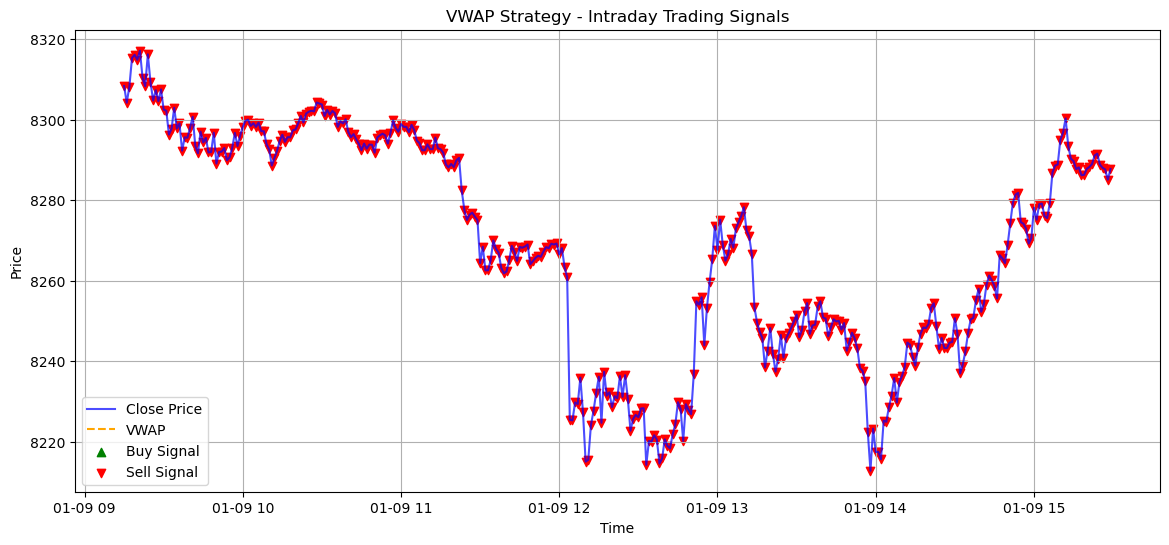

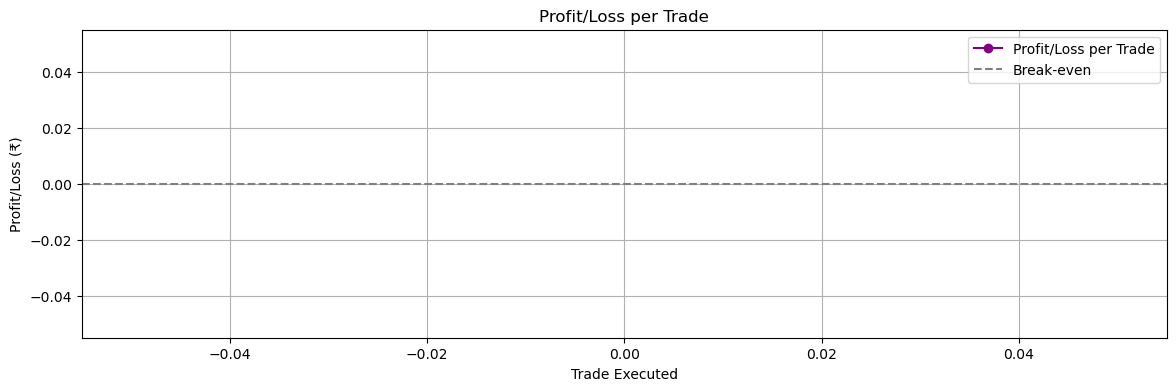

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load NSE intraday data
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by time
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# Calculate VWAP
df['Cumulative_Volume'] = df['volume'].cumsum()
df['Cumulative_Price_Volume'] = (df['close'] * df['volume']).cumsum()

# VWAP = Cumulative Price-Volume / Cumulative Volume
df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

# Generate Buy and Sell Signals based on VWAP
df['Signal'] = np.where(df['close'] > df['VWAP'], 1, -1)  # 1 = Buy, -1 = Sell

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

# Track the number of trades
num_trades = 0
total_profit_loss = 0

for i in range(1, len(df)):
    # Buy Signal
    if df['Signal'].iloc[i] == 1 and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Sr. No.': num_trades + 1, 'Trade Time': df.index[i], 'Action': 'Buy', 'Price': entry_price})

    # Sell Signal
    elif df['Signal'].iloc[i] == -1 and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Sr. No.': num_trades + 1,
            'Trade Time': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit/Loss': final_profit_loss
        })

        position = None  # Reset position after the trade

        num_trades += 1  # Increase trade count

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Total Profit/Loss from all trades: ₹{total_profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and VWAP
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.plot(df.index, df['VWAP'], label='VWAP', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('VWAP Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit/Loss'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Supertrend Strategy

Initial Balance: ₹10000
Final Balance: ₹9949.49
Total Profit/Loss: ₹-50.51

Trade Log:
                 Date Action    Price     Profit
0 2015-01-09 12:52:00    Buy  8254.90   0.000000
1 2015-01-09 13:57:00   Sell  8222.35 -50.513132


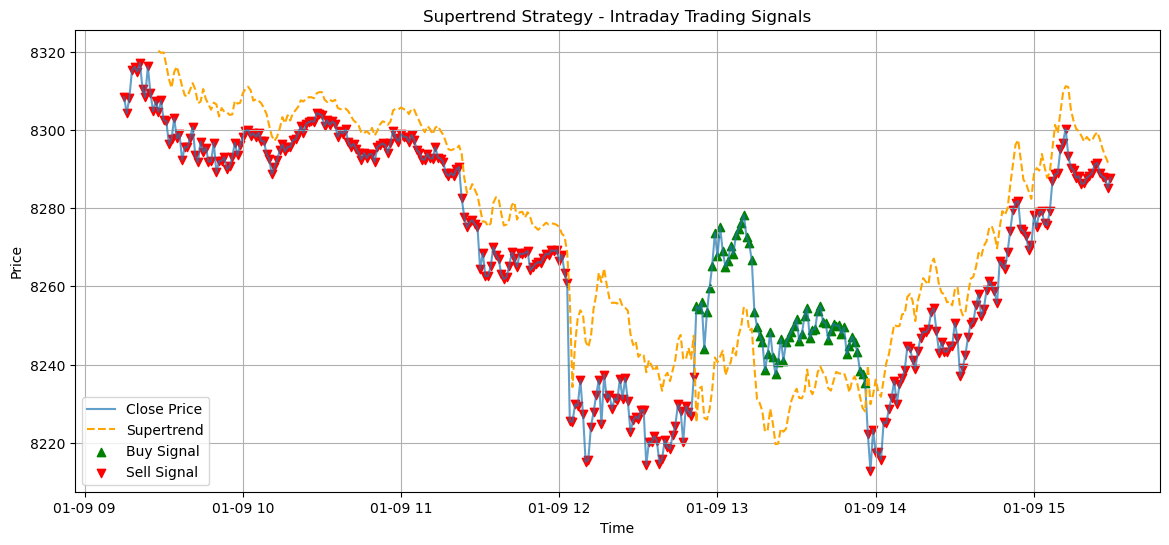

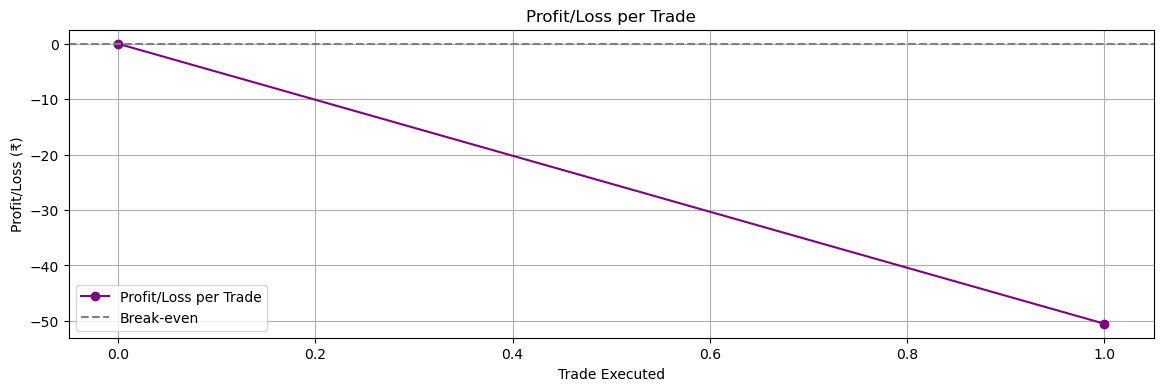

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load NSE intraday data
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by time
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# Calculate ATR (Average True Range)
df['H-L'] = df['high'] - df['low']
df['H-PC'] = abs(df['high'] - df['close'].shift(1))
df['L-PC'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()  # Using 14-period ATR

# Supertrend calculation
multiplier = 3  # Multiplier for the Supertrend
df['Basic_Upper_Band'] = (df['high'] + df['low']) / 2 + multiplier * df['ATR']
df['Basic_Lower_Band'] = (df['high'] + df['low']) / 2 - multiplier * df['ATR']

# Initialize Supertrend column
df['Supertrend'] = np.nan

# Calculate Supertrend using .loc for safe assignment
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['Supertrend'].iloc[i-1]:
        df.loc[df.index[i], 'Supertrend'] = df['Basic_Lower_Band'].iloc[i]
    else:
        df.loc[df.index[i], 'Supertrend'] = df['Basic_Upper_Band'].iloc[i]

# Generate Buy and Sell signals
df['Signal'] = np.where(df['close'] > df['Supertrend'], 1, -1)  # 1 = Buy, -1 = Sell

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal
    if df['Signal'].iloc[i] == 1 and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal
    elif df['Signal'].iloc[i] == -1 and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss  # Only calculate profit on Sell
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Supertrend
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7)
plt.plot(df.index, df['Supertrend'], label='Supertrend', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Supertrend Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
RSI & MACD Strategy

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


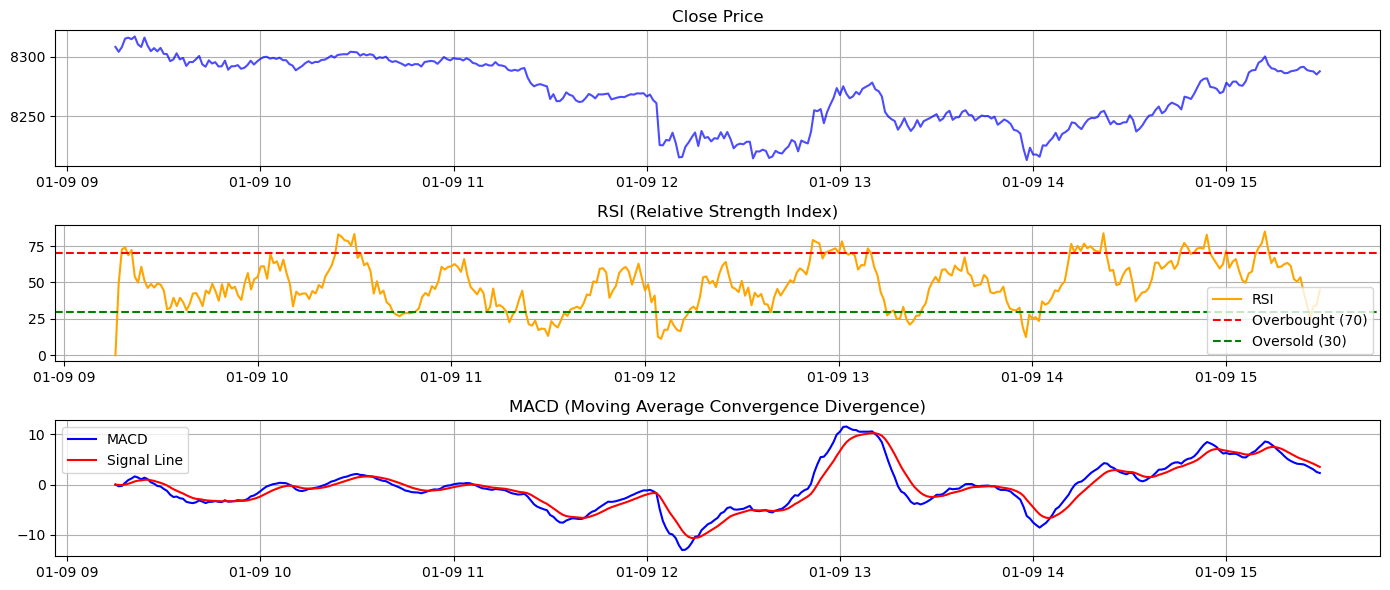

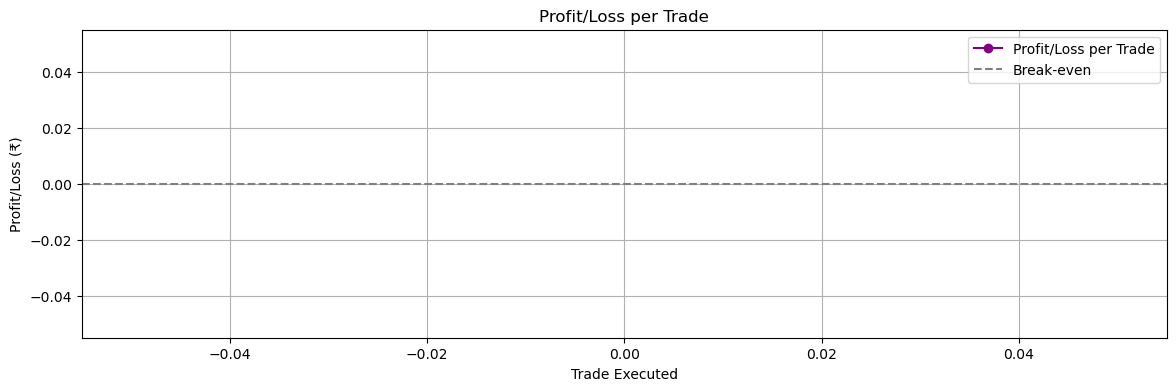

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- RSI Calculation ---
# Define RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI (14-period)
df['RSI'] = calculate_rsi(df['close'], window=14)

# --- MACD Calculation ---
# Calculate MACD and Signal Line
short_ema = df['close'].ewm(span=12, min_periods=1, adjust=False).mean()
long_ema = df['close'].ewm(span=26, min_periods=1, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['Signal_Line'] = df['MACD'].ewm(span=9, min_periods=1, adjust=False).mean()

# --- Generate Buy and Sell Signals ---
# Buy Signal: RSI < 30 and MACD crosses above Signal Line
df['Buy_Signal'] = (df['RSI'] < 30) & (df['MACD'] > df['Signal_Line'])

# Sell Signal: RSI > 70 and MACD crosses below Signal Line
df['Sell_Signal'] = (df['RSI'] > 70) & (df['MACD'] < df['Signal_Line'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, RSI, MACD, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.title('Close Price')
plt.grid(True)

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (Relative Strength Index)')
plt.legend(loc='best')
plt.grid(True)

# Plot MACD and Signal Line
plt.subplot(3, 1, 3)
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Bollinger Bands Strategy

Initial Balance: ₹10000
Final Balance: ₹9933.61
Total Profit/Loss: ₹-66.39

Trade Log:
                 Date Action    Price     Profit
0 2015-01-09 10:40:00    Buy  8296.95   0.000000
1 2015-01-09 12:51:00   Sell  8236.80 -78.177201
2 2015-01-09 13:15:00    Buy  8249.60   0.000000
3 2015-01-09 14:52:00   Sell  8279.40  11.786072


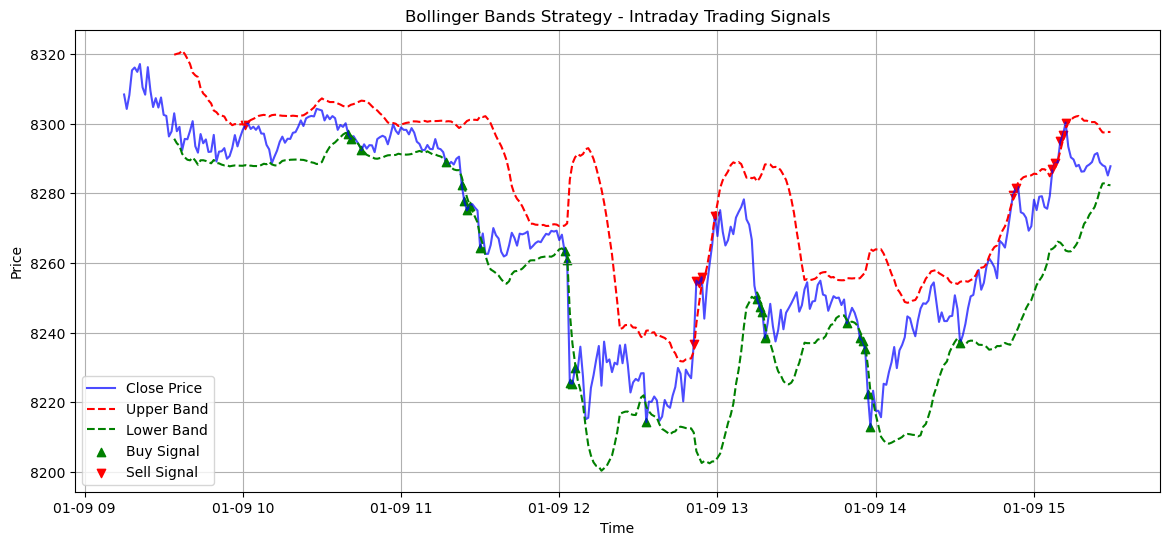

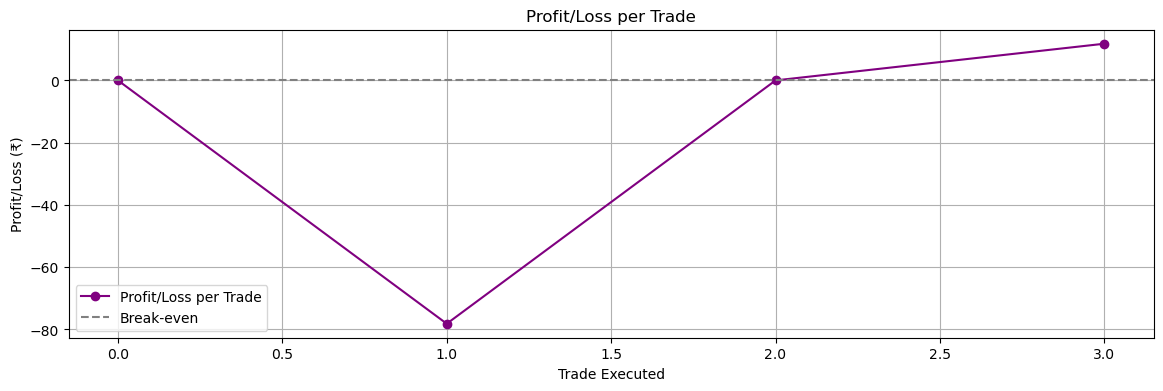

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Bollinger Bands Calculation ---
window = 20  # 20-period moving average
num_std = 2  # Standard deviations for upper and lower bands

# Calculate the moving average and rolling standard deviation
df['SMA'] = df['close'].rolling(window=window).mean()
df['Rolling_STD'] = df['close'].rolling(window=window).std()

# Calculate the upper and lower Bollinger Bands
df['Upper_Band'] = df['SMA'] + (df['Rolling_STD'] * num_std)
df['Lower_Band'] = df['SMA'] - (df['Rolling_STD'] * num_std)

# --- Generate Buy and Sell signals ---
df['Buy_Signal'] = (df['close'] < df['Lower_Band'])  # Buy when price touches or crosses below the lower band
df['Sell_Signal'] = (df['close'] > df['Upper_Band'])  # Sell when price touches or crosses above the upper band

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, Bollinger Bands, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.plot(df.index, df['Upper_Band'], label='Upper Band', linestyle="--", color='red')
plt.plot(df.index, df['Lower_Band'], label='Lower Band', linestyle="--", color='green')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Bollinger Bands Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
CPR (Central Pivot Range) Strategy

Initial Balance: ₹10000
Final Balance: ₹8451.93
Total Profit/Loss: ₹-1548.07

Trade Log:
                   Date Action    Price     Profit
0   2015-01-09 09:17:00    Buy  8308.20   0.000000
1   2015-01-09 09:20:00   Sell  8314.85 -11.468526
2   2015-01-09 09:21:00    Buy  8317.10   0.000000
3   2015-01-09 09:22:00   Sell  8310.40 -24.824578
4   2015-01-09 09:24:00    Buy  8316.20   0.000000
..                  ...    ...      ...        ...
170 2015-01-09 15:09:00    Buy  8288.85   0.000000
171 2015-01-09 15:13:00   Sell  8293.40 -13.524243
172 2015-01-09 15:19:00    Buy  8286.30   0.000000
173 2015-01-09 15:24:00   Sell  8291.55 -12.819384
174 2015-01-09 15:29:00    Buy  8287.75   0.000000

[175 rows x 4 columns]


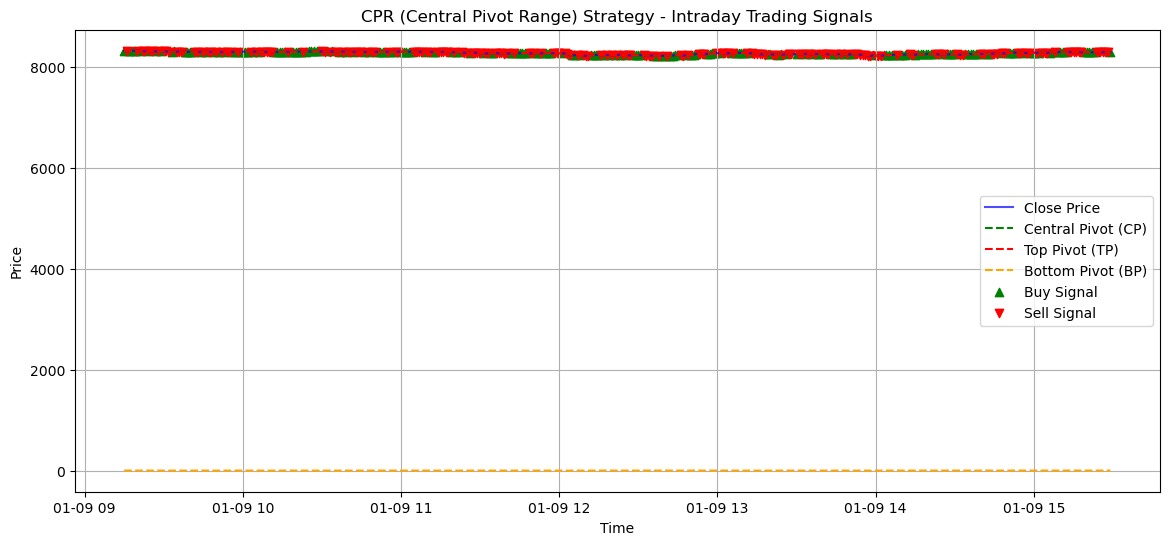

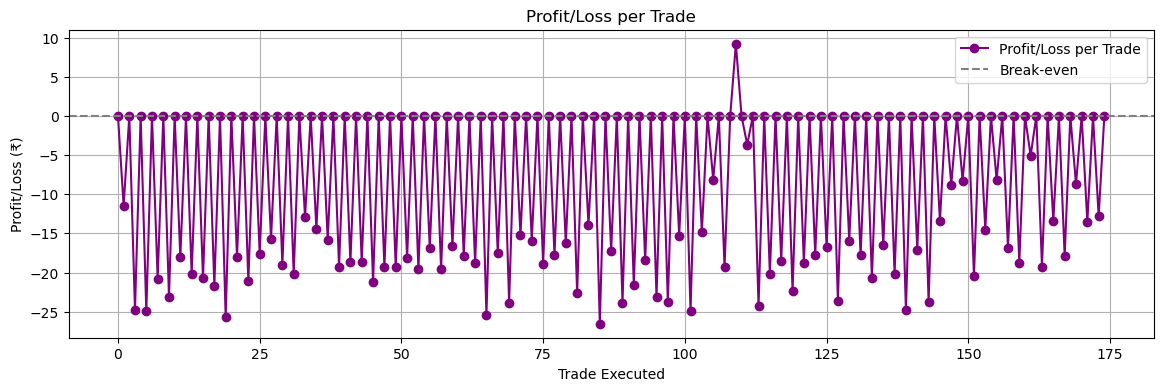

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate CPR (Central Pivot Range) ---
# Calculate the Central Pivot (CP), Top Pivot (TP), and Bottom Pivot (BP) for CPR strategy
df['CP'] = (df['high'] + df['low'] + df['close']) / 3  # Central Pivot
df['TP'] = (df['high'] + df['low']) / 2  # Top Pivot
df['BP'] = (df['CP'] - df['TP']) / 2  # Bottom Pivot

# --- Generate Buy and Sell signals based on CPR ---
df['Buy_Signal'] = df['close'] > df['CP']  # Buy when price is above the CP
df['Sell_Signal'] = df['close'] < df['CP']  # Sell when price is below the CP

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, CPR, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')
plt.plot(df.index, df['CP'], label='Central Pivot (CP)', linestyle="--", color='green')
plt.plot(df.index, df['TP'], label='Top Pivot (TP)', linestyle="--", color='red')
plt.plot(df.index, df['BP'], label='Bottom Pivot (BP)', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('CPR (Central Pivot Range) Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
ORB (Opening Range Breakout) Strategy

Opening Range High (ORH): 8317.25
Opening Range Low (ORL): 8300.6
Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


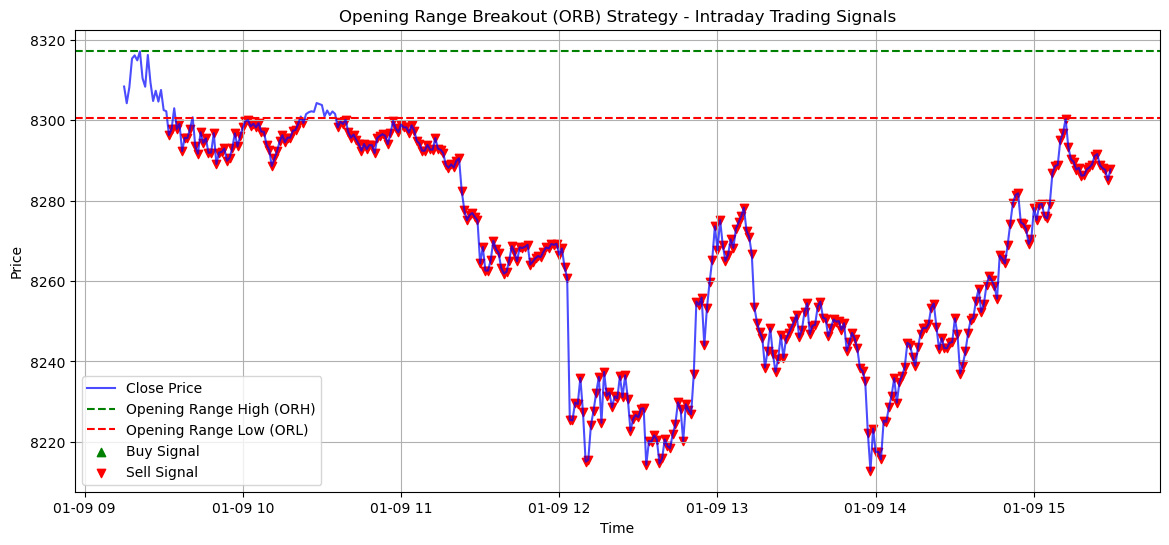

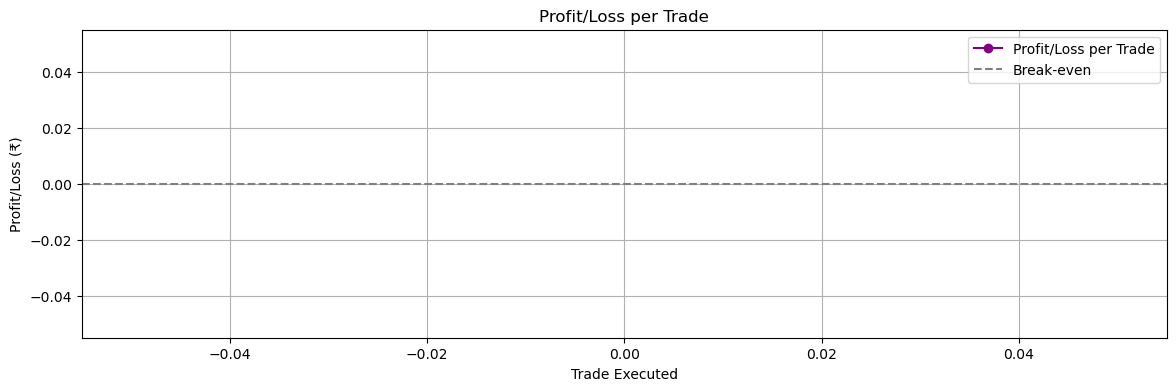

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Define the Opening Range ---
# Define the opening range duration (e.g., first 15 minutes)
opening_range_duration = 15  # minutes
start_time = df.index[0]  # Market open time
end_time = start_time + pd.Timedelta(minutes=opening_range_duration)

# Filter the data for the opening range (first 15 minutes)
opening_range_data = df[(df.index >= start_time) & (df.index <= end_time)]

# Calculate the Opening Range High and Low
ORH = opening_range_data['high'].max()  # Highest point in the first 15 minutes
ORL = opening_range_data['low'].min()   # Lowest point in the first 15 minutes

print(f"Opening Range High (ORH): {ORH}")
print(f"Opening Range Low (ORL): {ORL}")

# --- Generate Buy and Sell signals ---
# Buy Signal: Price crosses above ORH
# Sell Signal: Price crosses below ORL

df['Buy_Signal'] = df['close'] > ORH  # Buy when the price is above ORH
df['Sell_Signal'] = df['close'] < ORL  # Sell when the price is below ORL

# --- Track Profits and Losses ---
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Opening Range High and Low
plt.axhline(y=ORH, color='green', linestyle="--", label='Opening Range High (ORH)')
plt.axhline(y=ORL, color='red', linestyle="--", label='Opening Range Low (ORL)')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Opening Range Breakout (ORB) Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Inside Bar Strategy (Price Action-Based)

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


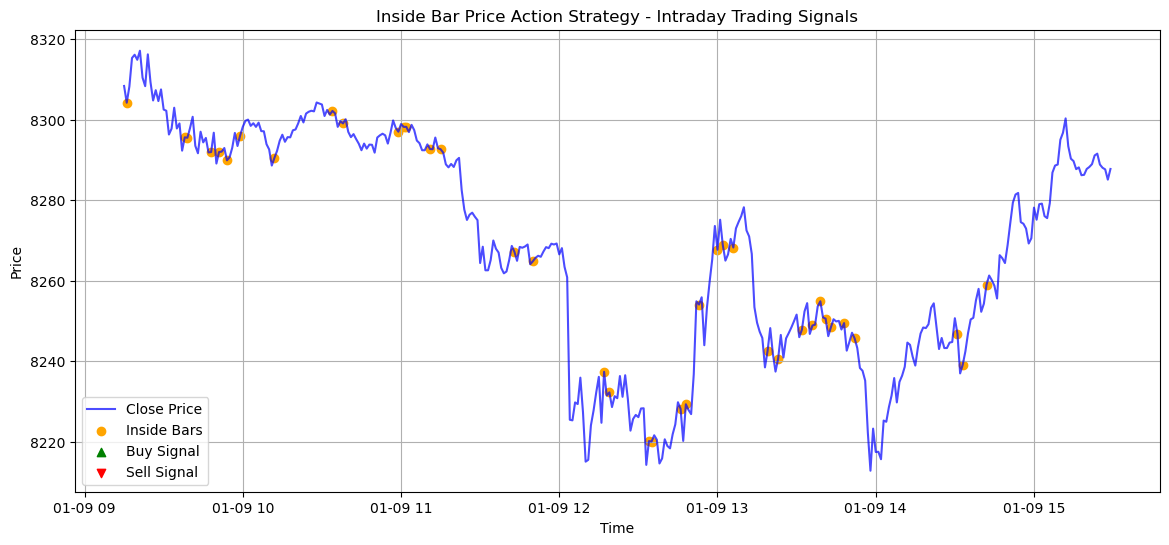

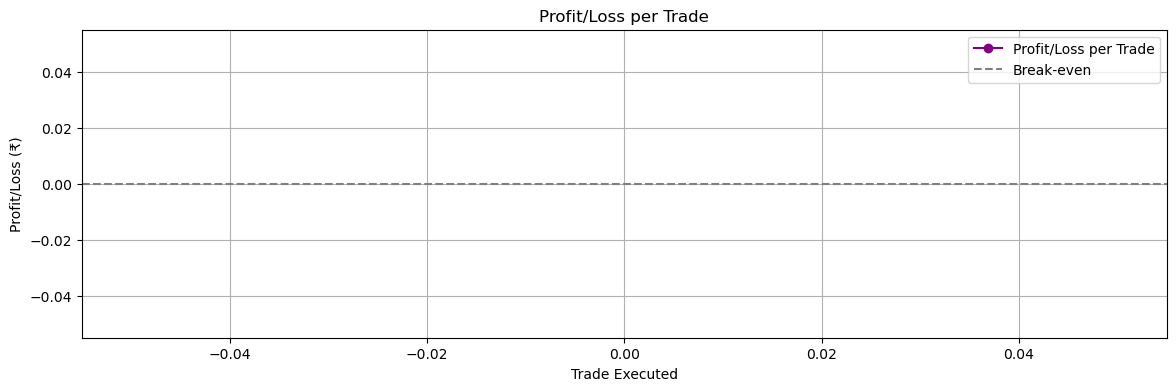

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Detect Inside Bars ---
df['Inside_Bar'] = (df['high'] < df['high'].shift(1)) & (df['low'] > df['low'].shift(1))

# --- Generate Buy and Sell signals ---
# Buy Signal: Price breaks above the high of the inside bar
df['Buy_Signal'] = df['Inside_Bar'] & (df['close'] > df['high'].shift(1))

# Sell Signal: Price breaks below the low of the inside bar
df['Sell_Signal'] = df['Inside_Bar'] & (df['close'] < df['low'].shift(1))

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Highlight Inside Bars
inside_bars = df[df['Inside_Bar']]
plt.scatter(inside_bars.index, inside_bars['close'], marker='o', color='orange', label='Inside Bars', alpha=1)

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Inside Bar Price Action Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Heikin-Ashi Trend Strategy

Initial Balance: ₹10000
Final Balance: ₹8756.60
Total Profit/Loss: ₹-1243.40

Trade Log:
                   Date Action    Price     Profit
0   2015-01-09 09:16:00    Buy  8304.20   0.000000
1   2015-01-09 09:17:00   Sell  8308.20 -14.107156
2   2015-01-09 09:18:00    Buy  8315.30   0.000000
3   2015-01-09 09:20:00   Sell  8314.85 -18.576904
4   2015-01-09 09:21:00    Buy  8317.10   0.000000
..                  ...    ...      ...        ...
129 2015-01-09 15:04:00   Sell  8276.05 -21.145447
130 2015-01-09 15:06:00    Buy  8279.25   0.000000
131 2015-01-09 15:13:00   Sell  8293.40  -3.912915
132 2015-01-09 15:20:00    Buy  8287.75   0.000000
133 2015-01-09 15:25:00   Sell  8288.85 -16.968395

[134 rows x 4 columns]


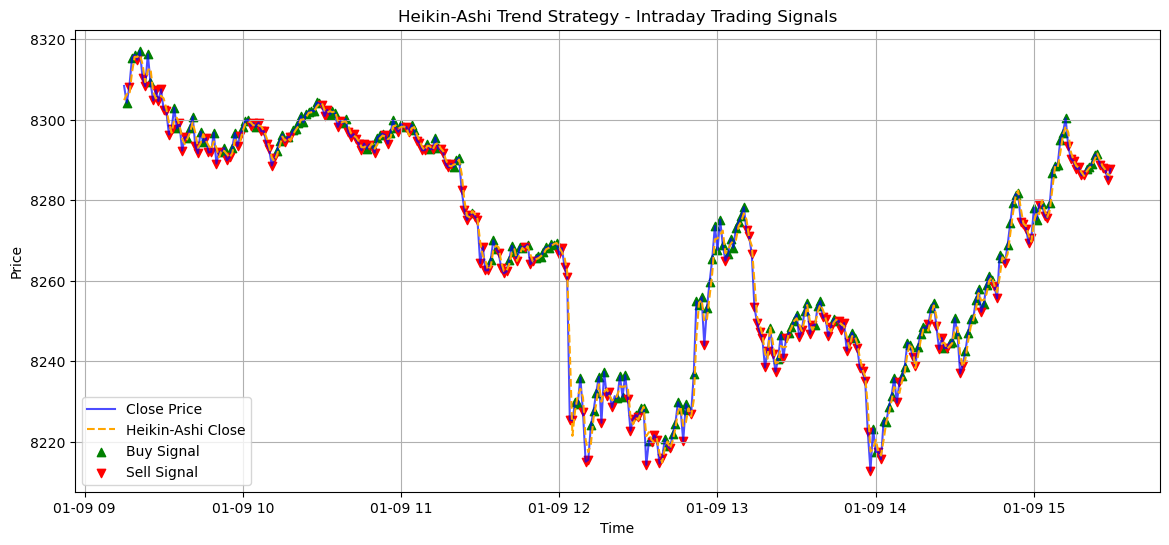

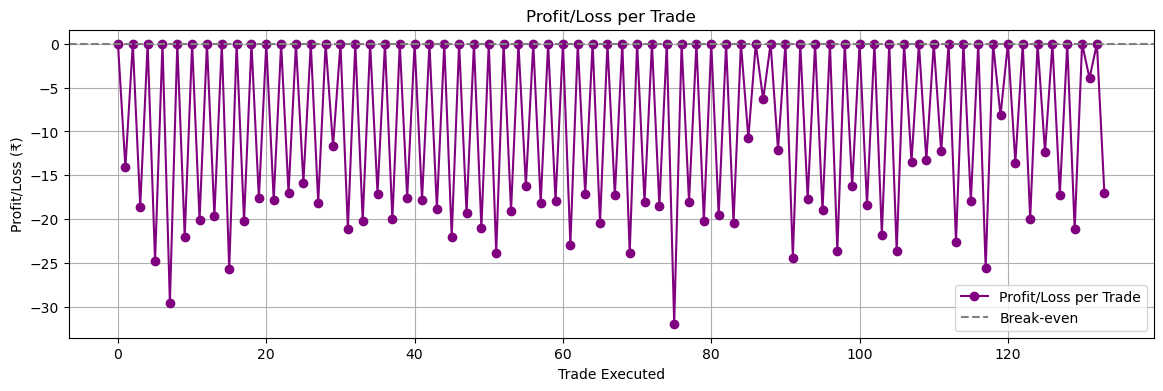

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate Heikin-Ashi Candles ---
df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4  # Heikin-Ashi Close
df['HA_Open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2  # Heikin-Ashi Open (shifted by 1 to get previous open and close)
df['HA_High'] = df[['high', 'HA_Open', 'HA_Close']].max(axis=1)  # Heikin-Ashi High
df['HA_Low'] = df[['low', 'HA_Open', 'HA_Close']].min(axis=1)  # Heikin-Ashi Low

# --- Generate Buy and Sell signals based on Heikin-Ashi Trend ---
# Buy Signal: Heikin-Ashi candles are bullish (close > open)
df['Buy_Signal'] = (df['HA_Close'] > df['HA_Open'])

# Sell Signal: Heikin-Ashi candles are bearish (close < open)
df['Sell_Signal'] = (df['HA_Close'] < df['HA_Open'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Heikin-Ashi Candles and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Heikin-Ashi candles
plt.plot(df.index, df['HA_Close'], label='Heikin-Ashi Close', linestyle="--", color='orange')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Heikin-Ashi Trend Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Fibonacci Retracement Strategy (Best for Pullbacks)

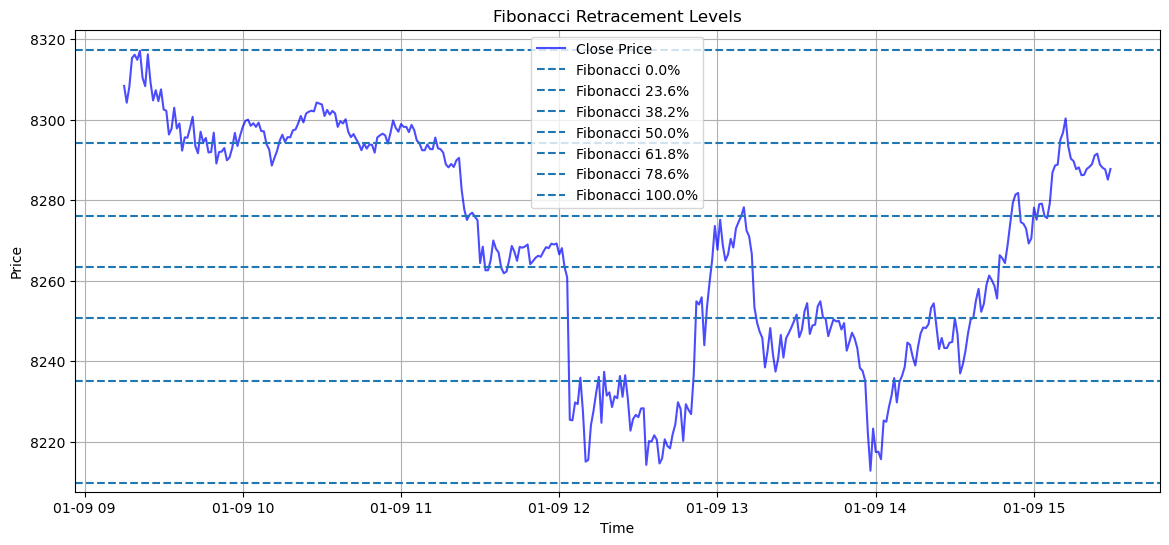

Initial Balance: ₹10000
Final Balance: ₹9947.15
Total Profit/Loss: ₹-52.85

Trade Log:
                 Date Action    Price     Profit
0 2015-01-09 11:32:00    Buy  8262.60   0.000000
1 2015-01-09 11:34:00   Sell  8265.15 -15.465018
2 2015-01-09 11:38:00    Buy  8263.20   0.000000
3 2015-01-09 11:41:00   Sell  8265.10 -16.115676
4 2015-01-09 12:02:00    Buy  8263.45   0.000000
5 2015-01-09 12:58:00   Sell  8265.30 -16.166171
6 2015-01-09 13:14:00    Buy  8253.45   0.000000
7 2015-01-09 14:47:00   Sell  8266.35  -5.105421


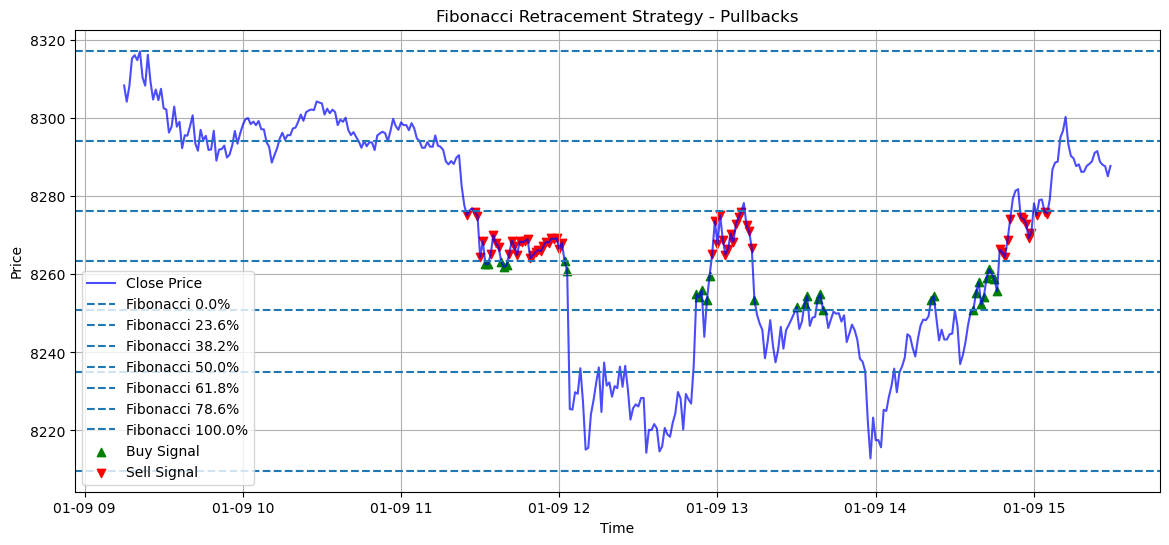

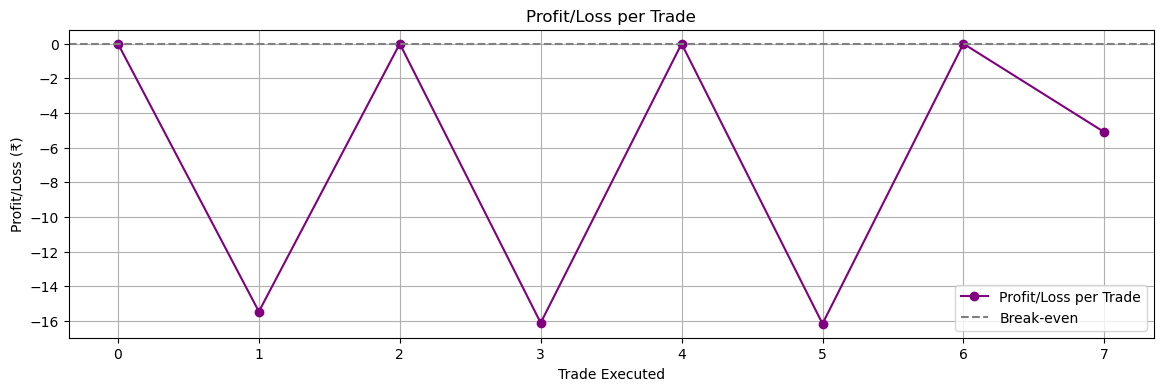

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Define Fibonacci Retracement Levels ---
# Let's assume we are in an uptrend and we calculate Fibonacci retracement levels from a significant swing low to swing high.

# Swing low and swing high (adjust based on your timeframe and chart)
swing_low = df['low'].min()  # Adjust if necessary to pick the exact swing low
swing_high = df['high'].max()  # Adjust if necessary to pick the exact swing high

# Fibonacci Retracement Levels
fibonacci_levels = {
    '0.0%': swing_low,
    '23.6%': swing_low + 0.236 * (swing_high - swing_low),
    '38.2%': swing_low + 0.382 * (swing_high - swing_low),
    '50.0%': swing_low + 0.5 * (swing_high - swing_low),
    '61.8%': swing_low + 0.618 * (swing_high - swing_low),
    '78.6%': swing_low + 0.786 * (swing_high - swing_low),
    '100.0%': swing_high
}

# --- Plot Fibonacci Retracement Levels ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Fibonacci levels
for level, price in fibonacci_levels.items():
    plt.axhline(price, label=f'Fibonacci {level}', linestyle="--")

plt.title('Fibonacci Retracement Levels')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Generate Buy and Sell signals based on Fibonacci Retracement ---
# For Buy Signal: Price should be at or near a Fibonacci retracement level and then start to move up
df['Buy_Signal'] = (df['close'] > fibonacci_levels['38.2%']) & (df['close'] < fibonacci_levels['50.0%'])

# For Sell Signal: Price should be at or near a Fibonacci retracement level and then start to move down
df['Sell_Signal'] = (df['close'] > fibonacci_levels['50.0%']) & (df['close'] < fibonacci_levels['61.8%'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot Fibonacci levels
for level, price in fibonacci_levels.items():
    plt.axhline(price, label=f'Fibonacci {level}', linestyle="--")

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Fibonacci Retracement Strategy - Pullbacks')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
  Donchian Channel Breakout Strategy

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


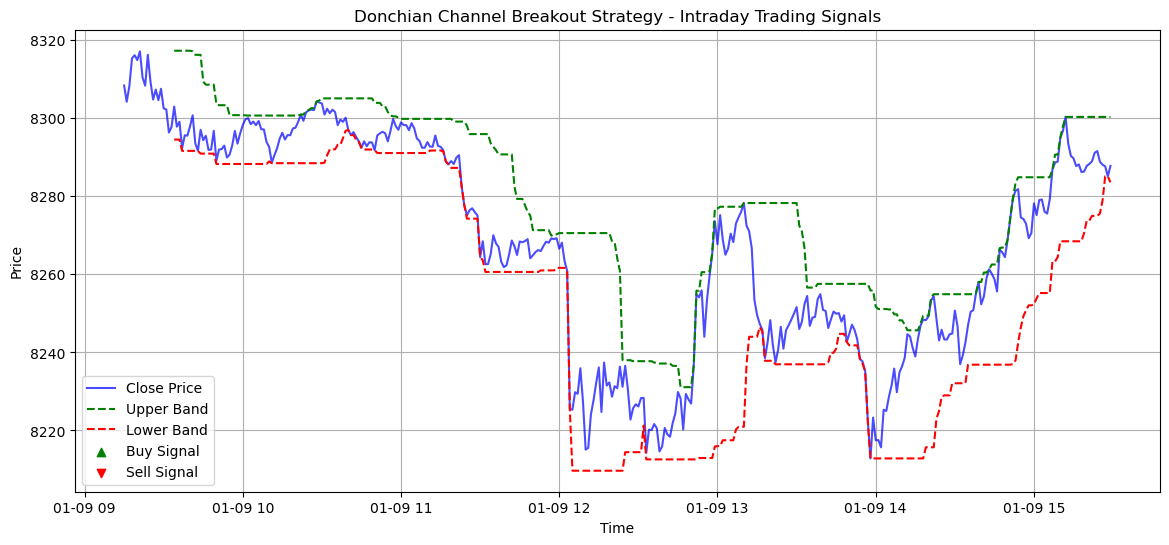

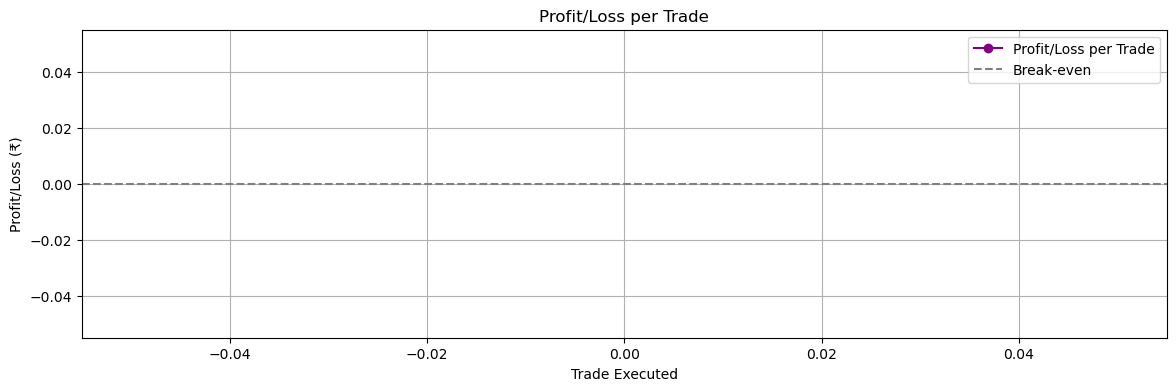

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Define Donchian Channel ---
# Define the period for the Donchian Channel (e.g., 20-period)
channel_period = 20

# Calculate the Upper and Lower Bands of the Donchian Channel
df['Upper_Band'] = df['high'].rolling(window=channel_period).max()  # 20-period Upper Band
df['Lower_Band'] = df['low'].rolling(window=channel_period).min()   # 20-period Lower Band

# --- Generate Buy and Sell signals based on Donchian Channel Breakout ---
# Buy Signal: Price crosses above the Upper Band
df['Buy_Signal'] = df['close'] > df['Upper_Band']

# Sell Signal: Price crosses below the Lower Band
df['Sell_Signal'] = df['close'] < df['Lower_Band']

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, Donchian Channel, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot the Upper and Lower Bands of the Donchian Channel
plt.plot(df.index, df['Upper_Band'], label='Upper Band', linestyle="--", color='green')
plt.plot(df.index, df['Lower_Band'], label='Lower Band', linestyle="--", color='red')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('Donchian Channel Breakout Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
EMA Ribbon Strategy (Exponential Moving Averages)

Initial Balance: ₹10000
Final Balance: ₹9861.53
Total Profit/Loss: ₹-138.47

Trade Log:
                  Date Action    Price     Profit
0  2015-01-09 09:18:00    Buy  8315.30   0.000000
1  2015-01-09 09:28:00   Sell  8304.60 -28.816654
2  2015-01-09 10:03:00    Buy  8298.45   0.000000
3  2015-01-09 10:10:00   Sell  8292.60 -23.934771
4  2015-01-09 10:20:00    Buy  8297.55   0.000000
5  2015-01-09 10:41:00   Sell  8295.65 -19.986759
6  2015-01-09 11:00:00    Buy  8298.90   0.000000
7  2015-01-09 11:07:00   Sell  8294.15 -22.836852
8  2015-01-09 12:51:00    Buy  8236.80   0.000000
9  2015-01-09 13:18:00   Sell  8238.50 -16.257924
10 2015-01-09 13:39:00    Buy  8254.90   0.000000
11 2015-01-09 13:42:00   Sell  8246.25 -26.637032
12 2015-01-09 14:13:00    Buy  8244.10   0.000000


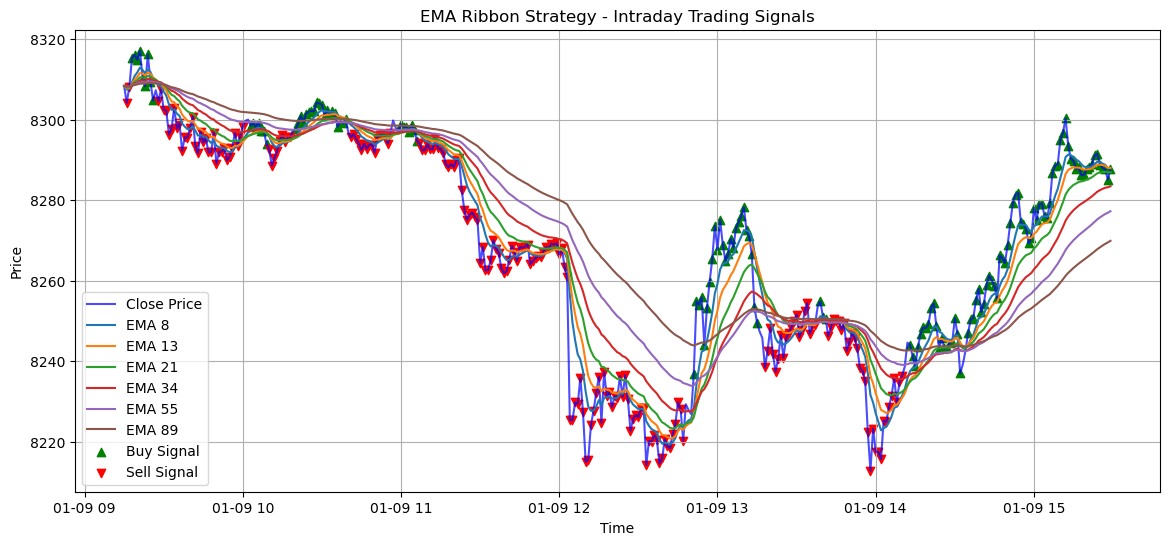

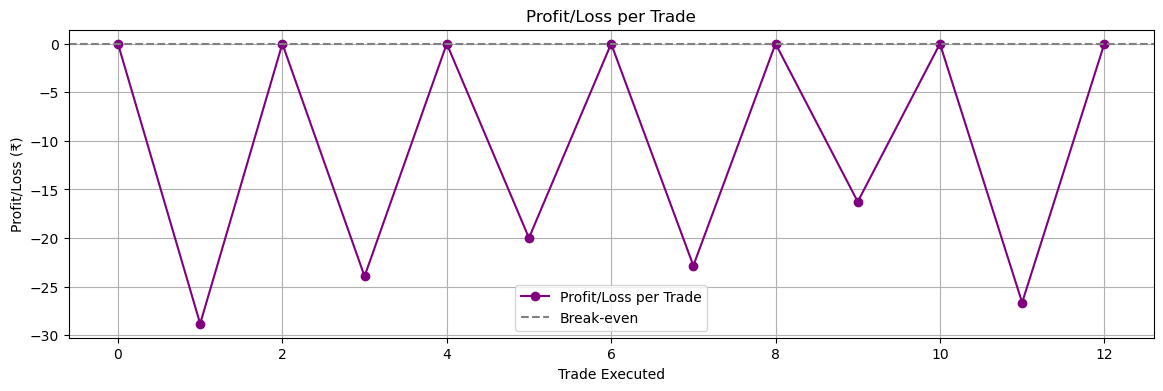

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate Multiple EMAs (for the EMA Ribbon) ---
# Define the periods for the EMAs (e.g., 8, 13, 21, 34, 55, 89)
ema_periods = [8, 13, 21, 34, 55, 89]

# Calculate the EMAs for the specified periods
for period in ema_periods:
    df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()

# --- Generate Buy and Sell Signals based on EMA Ribbon ---
# Buy Signal: Short-term EMAs cross above the long-term EMAs (e.g., 8-period EMA crosses above 21-period EMA)
df['Buy_Signal'] = (df['EMA_8'] > df['EMA_21']) & (df['EMA_13'] > df['EMA_21'])

# Sell Signal: Short-term EMAs cross below the long-term EMAs (e.g., 8-period EMA crosses below 21-period EMA)
df['Sell_Signal'] = (df['EMA_8'] < df['EMA_21']) & (df['EMA_13'] < df['EMA_21'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Plot the EMA Ribbon
for period in ema_periods:
    plt.plot(df.index, df[f'EMA_{period}'], label=f'EMA {period}')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('EMA Ribbon Strategy - Intraday Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
 ATR Trailing Stop Strategy

Initial Balance: ₹10000
Final Balance: ₹10033.10
Total Profit/Loss: ₹33.10


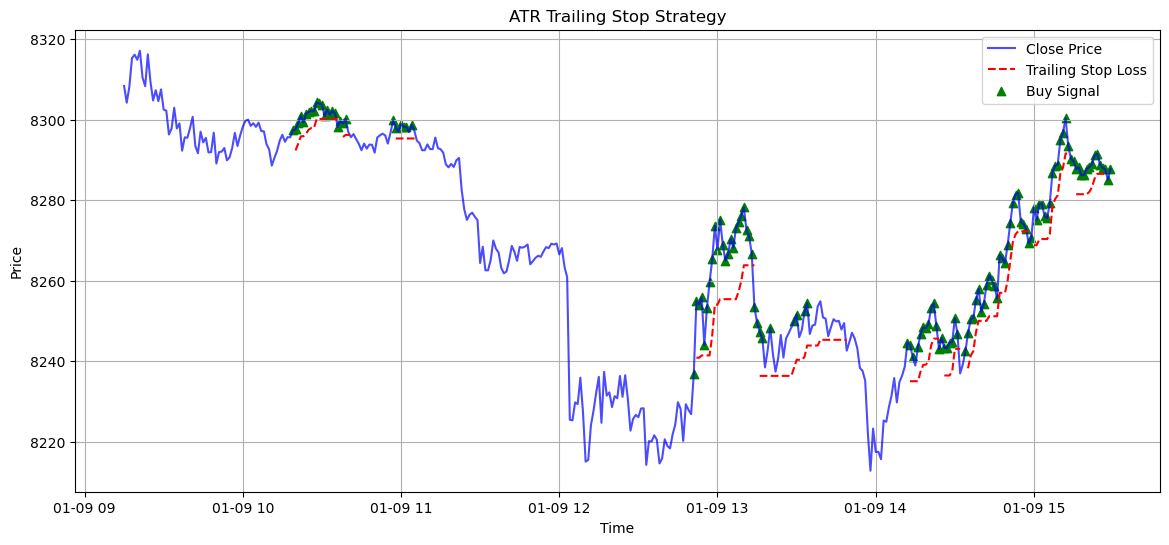

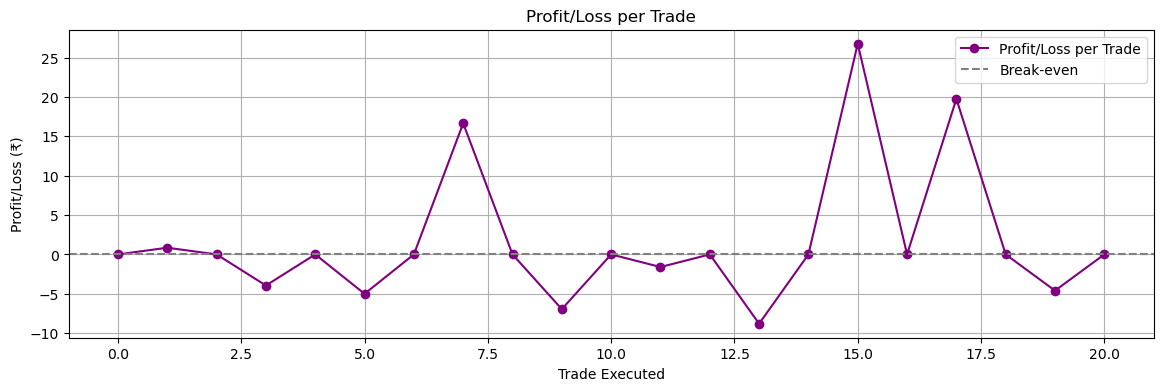

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index
df.set_index("date", inplace=True)

# --- Calculate ATR (Average True Range) ---
df['High_Low'] = df['high'] - df['low']
df['High_Close'] = abs(df['high'] - df['close'].shift(1))
df['Low_Close'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()

# --- ATR Trailing Stop Strategy ---
atr_multiple = 2
sma_period = 50

# Calculate SMA (Simple Moving Average)
df['SMA'] = df['close'].rolling(window=sma_period).mean()
df['Buy_Signal'] = df['close'] > df['SMA']

# --- Implement Trailing Stop Logic ---
position = None
entry_price = None
stop_loss = None
balance = 10000
trade_log = []
stop_loss_list = [np.nan] * len(df)  # Initialize list with NaN values

# Simulate the strategy
for i in range(1, len(df)):
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        # Enter Buy position
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        stop_loss = entry_price - (atr_multiple * df['ATR'].iloc[i])
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Stop Loss': stop_loss, 'Profit': 0})

    elif position == 'Buy':
        # Update stop-loss dynamically (ATR Trailing Stop)
        stop_loss = max(stop_loss, df['close'].iloc[i] - (atr_multiple * df['ATR'].iloc[i]))
        stop_loss_list[i] = stop_loss

        # Sell if price hits stop-loss
        if df['close'].iloc[i] <= stop_loss:
            sell_price = df['close'].iloc[i]
            profit = sell_price - entry_price
            balance += profit
            trade_log.append({'Date': df.index[i], 'Action': 'Sell', 'Price': sell_price, 'Stop Loss': stop_loss, 'Profit': profit})
            position = None

# Convert trade log to DataFrame
trade_df = pd.DataFrame(trade_log)
trade_df.fillna(0, inplace=True)

# Final Balance Calculation
final_balance = balance
profit_loss = final_balance - 10000

# Print Results
print(f"Initial Balance: ₹10000")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# --- Plot Close Price, Stop Loss, and Buy/Sell signals ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7, color='blue')

# Ensure stop_loss_list is correctly aligned with df.index
plt.plot(df.index, stop_loss_list, label='Trailing Stop Loss', linestyle="--", color='red')

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)

plt.legend()
plt.title('ATR Trailing Stop Strategy')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# --- Plot Profit/Loss per Trade ---
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
ADX Trend Strength Strategy

Initial Balance: ₹10000
Final Balance: ₹9893.82
Total Profit/Loss: ₹-106.18

Trade Log:
                  Date Action    Price     Profit
0  2015-01-09 09:57:00    Buy  8296.70   0.000000
1  2015-01-09 10:11:00   Sell  8288.60 -26.178706
2  2015-01-09 10:25:00    Buy  8301.95   0.000000
3  2015-01-09 10:40:00   Sell  8296.95 -23.093251
4  2015-01-09 10:59:00    Buy  8297.00   0.000000
5  2015-01-09 11:08:00   Sell  8292.40 -22.682860
6  2015-01-09 12:52:00    Buy  8254.90   0.000000
7  2015-01-09 13:14:00   Sell  8253.45 -19.444232
8  2015-01-09 13:32:00    Buy  8247.85   0.000000
9  2015-01-09 13:48:00   Sell  8249.50 -16.331963
10 2015-01-09 14:11:00    Buy  8238.65   0.000000
11 2015-01-09 14:27:00   Sell  8243.30 -13.314907
12 2015-01-09 14:38:00    Buy  8255.15   0.000000
13 2015-01-09 15:26:00   Sell  8288.05  14.870873


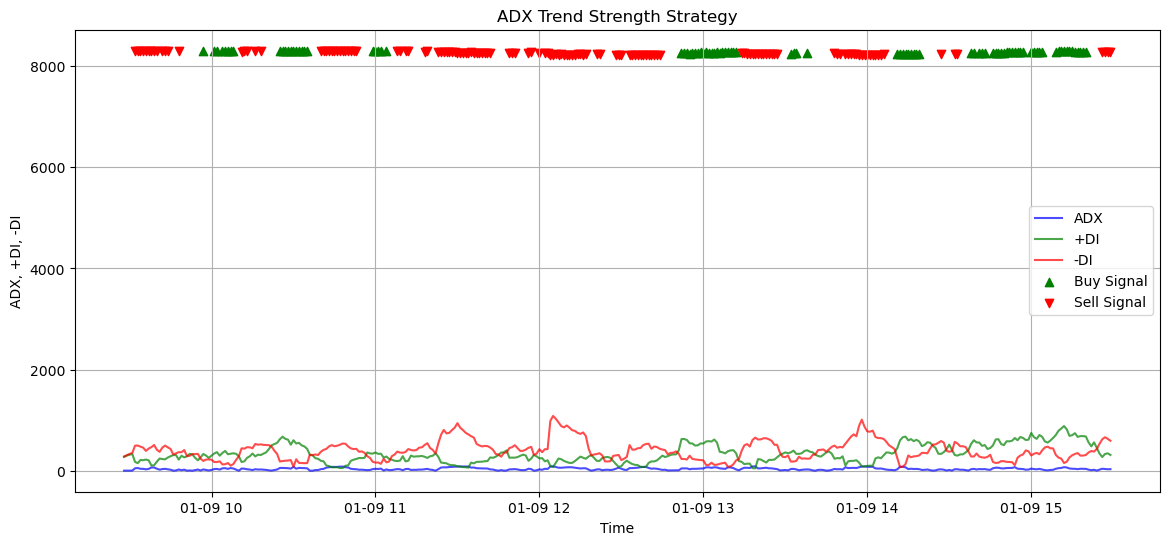

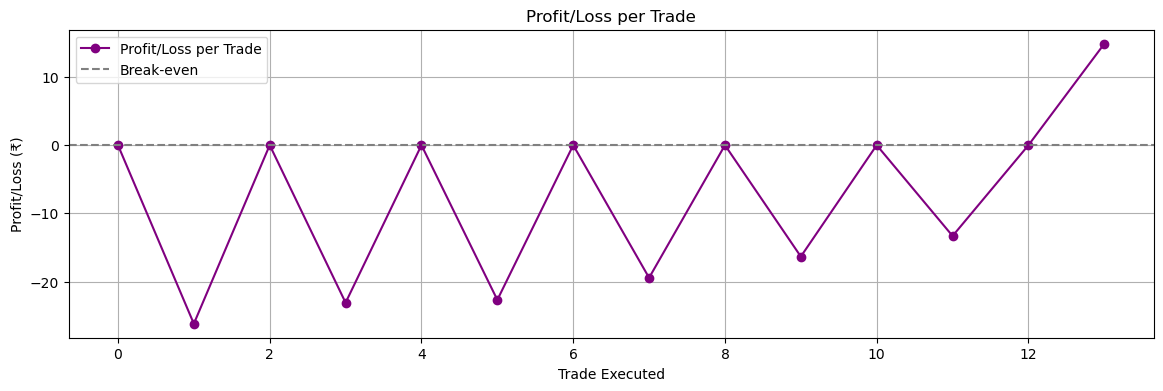

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Calculate ADX, +DI, and -DI ---
# Calculate True Range (TR) for each period
df['High_Low'] = df['high'] - df['low']
df['High_Close'] = abs(df['high'] - df['close'].shift(1))
df['Low_Close'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# Calculate +DM and -DM
df['+DM'] = df['high'] - df['high'].shift(1)
df['-DM'] = df['low'].shift(1) - df['low']

# Apply conditions for +DM and -DM
df['+DM'] = np.where(df['+DM'] > df['-DM'], df['+DM'], 0)
df['-DM'] = np.where(df['-DM'] > df['+DM'], df['-DM'], 0)

# Calculate the smoothed moving averages
df['ATR'] = df['TR'].rolling(window=14).mean()
df['+DI'] = 100 * (df['+DM'].rolling(window=14).sum() / df['ATR'])
df['-DI'] = 100 * (df['-DM'].rolling(window=14).sum() / df['ATR'])

# Calculate ADX (Average Directional Index)
df['ADX'] = 100 * (abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']))

# --- Generate Buy and Sell signals based on ADX Strategy ---
# Buy Signal: ADX > 25 and +DI crosses above -DI
df['Buy_Signal'] = (df['ADX'] > 25) & (df['+DI'] > df['-DI'])

# Sell Signal: ADX > 25 and -DI crosses above +DI
df['Sell_Signal'] = (df['ADX'] > 25) & (df['-DI'] > df['+DI'])

# Track Profits and Losses with Tax/Deductions (Optional)
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    # Buy Signal: Check for Buy condition and execute Buy action
    if df['Buy_Signal'].iloc[i] and position != 'Buy':
        position = 'Buy'
        entry_price = df['close'].iloc[i]
        trade_log.append({'Date': df.index[i], 'Action': 'Buy', 'Price': entry_price, 'Profit': 0})  # Profit is 0 for Buy

    # Sell Signal: Check for Sell condition and execute Sell action
    elif df['Sell_Signal'].iloc[i] and position == 'Buy':
        sell_price = df['close'].iloc[i]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs (Brokerage, GST, STT)
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            'Date': df.index[i],
            'Action': 'Sell',
            'Price': sell_price,
            'Profit': final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot ADX, +DI, -DI and Buy/Sell signals
plt.figure(figsize=(14, 6))

# Plot ADX, +DI, and -DI
plt.plot(df.index, df['ADX'], label='ADX', color='blue', alpha=0.7)
plt.plot(df.index, df['+DI'], label='+DI', color='green', alpha=0.7)
plt.plot(df.index, df['-DI'], label='-DI', color='red', alpha=0.7)

# Highlight Buy and Sell signals
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.legend()
plt.title('ADX Trend Strength Strategy')
plt.xlabel('Time')
plt.ylabel('ADX, +DI, -DI')
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade['Profit'] for trade in trade_log], label="Profit/Loss per Trade", color='purple', linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Parabolic SAR Strategy (Reversal Trading)

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


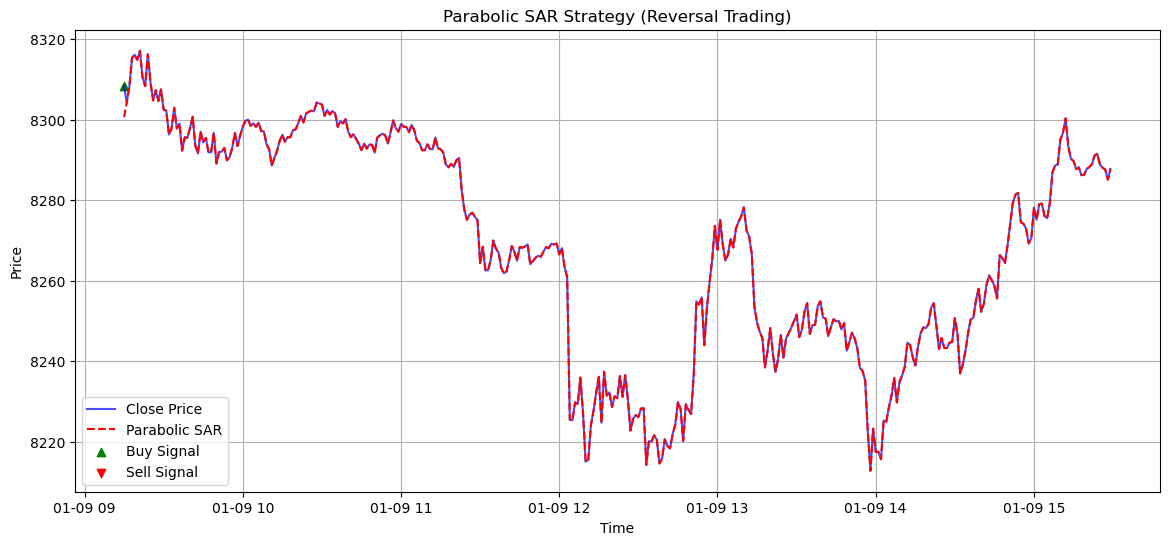

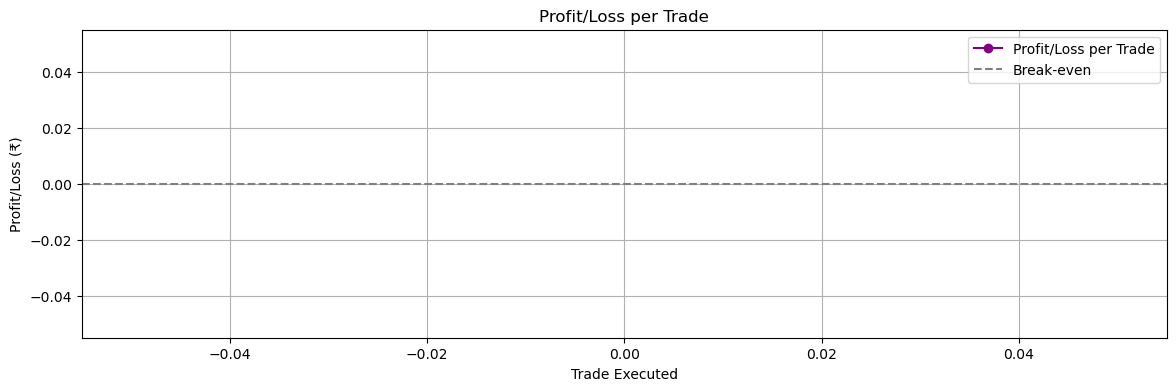

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure the data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Parabolic SAR Calculation ---
# Define the parameters for the Parabolic SAR
initial_af = 0.02  # Acceleration Factor
max_af = 0.2  # Maximum Acceleration Factor

# Initialize the columns for the Parabolic SAR, EP, and AF
df["SAR"] = np.nan
df["EP"] = np.nan  # Extreme Point
df["AF"] = initial_af  # Acceleration Factor
df["Trend"] = 1  # 1 for Uptrend, -1 for Downtrend

# Initialize the first values for SAR, EP, and AF using .loc[]
df.loc[df.index[0], "SAR"] = df.loc[df.index[0], "low"]  # Starting SAR value
df.loc[df.index[0], "EP"] = df.loc[df.index[0], "high"]  # Extreme Point is the highest high initially

# Calculate SAR for each row
for i in range(1, len(df)):
    prev_idx = df.index[i - 1]
    curr_idx = df.index[i]

    if df.loc[prev_idx, "Trend"] == 1:  # Uptrend
        df.loc[curr_idx, "SAR"] = df.loc[prev_idx, "SAR"] + df.loc[prev_idx, "AF"] * (df.loc[prev_idx, "EP"] - df.loc[prev_idx, "SAR"])
        df.loc[curr_idx, "EP"] = max(df.loc[prev_idx, "EP"], df.loc[curr_idx, "high"])
    else:  # Downtrend
        df.loc[curr_idx, "SAR"] = df.loc[prev_idx, "SAR"] + df.loc[prev_idx, "AF"] * (df.loc[prev_idx, "EP"] - df.loc[prev_idx, "SAR"])
        df.loc[curr_idx, "EP"] = min(df.loc[prev_idx, "EP"], df.loc[curr_idx, "low"])

    # Update the Acceleration Factor (AF) if the trend continues
    if df.loc[curr_idx, "SAR"] > df.loc[curr_idx, "close"]:
        df.loc[curr_idx, "SAR"] = df.loc[curr_idx, "close"]
        df.loc[curr_idx, "Trend"] = -1  # Change to Downtrend
        df.loc[curr_idx, "EP"] = df.loc[curr_idx, "low"]
        df.loc[curr_idx, "AF"] = initial_af  # Reset AF

    elif df.loc[curr_idx, "SAR"] < df.loc[curr_idx, "close"]:
        df.loc[curr_idx, "SAR"] = df.loc[curr_idx, "close"]
        df.loc[curr_idx, "Trend"] = 1  # Change to Uptrend
        df.loc[curr_idx, "EP"] = df.loc[curr_idx, "high"]
        df.loc[curr_idx, "AF"] = initial_af  # Reset AF

    # Update AF (acceleration factor)
    if df.loc[curr_idx, "Trend"] == df.loc[prev_idx, "Trend"]:
        df.loc[curr_idx, "AF"] = min(df.loc[prev_idx, "AF"] + 0.02, max_af)

# --- Generate Buy and Sell signals based on Parabolic SAR ---
df["Buy_Signal"] = df["SAR"] < df["close"]  # Buy when SAR is below the price
df["Sell_Signal"] = df["SAR"] > df["close"]  # Sell when SAR is above the price

# Track Profits and Losses with Tax/Deductions
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    curr_idx = df.index[i]

    # Buy Signal
    if df.loc[curr_idx, "Buy_Signal"] and position != "Buy":
        position = "Buy"
        entry_price = df.loc[curr_idx, "close"]
        trade_log.append({"Date": curr_idx, "Action": "Buy", "Price": entry_price, "Profit": 0})

    # Sell Signal
    elif df.loc[curr_idx, "Sell_Signal"] and position == "Buy":
        sell_price = df.loc[curr_idx, "close"]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            "Date": curr_idx,
            "Action": "Sell",
            "Price": sell_price,
            "Profit": final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# Plot Close Price, Parabolic SAR, and Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="Close Price", alpha=0.7, color="blue")

# Plot Parabolic SAR
plt.plot(df.index, df["SAR"], label="Parabolic SAR", linestyle="--", color="red")

# Highlight Buy and Sell signals
buy_signals = df[df["Buy_Signal"]]
sell_signals = df[df["Sell_Signal"]]
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title("Parabolic SAR Strategy (Reversal Trading)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Plot Profit/Loss per Trade
plt.figure(figsize=(14, 4))
plt.plot([trade["Profit"] for trade in trade_log], label="Profit/Loss per Trade", color="purple", linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Keltner Channel

Initial Balance: ₹10000
Final Balance: ₹9946.12
Total Profit/Loss: ₹-53.88

Trade Log:
                 Date Action    Price     Profit
0 2015-01-09 10:28:00    Buy  8304.25   0.000000
1 2015-01-09 10:44:00   Sell  8294.00 -28.343015
2 2015-01-09 12:52:00    Buy  8254.90   0.000000
3 2015-01-09 13:16:00   Sell  8247.35 -25.538132
4 2015-01-09 14:12:00    Buy  8244.65   0.000000


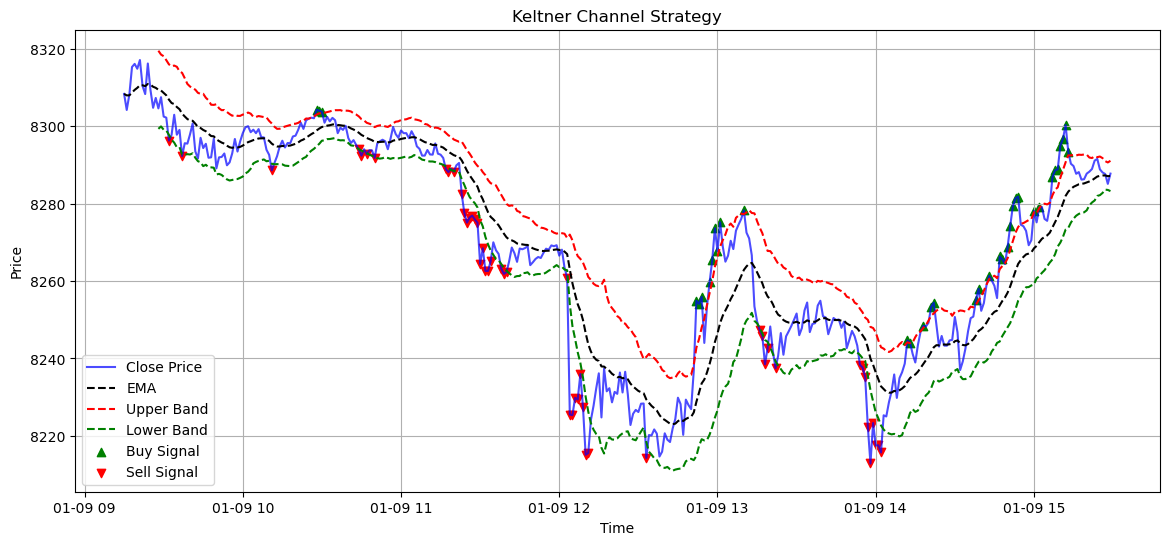

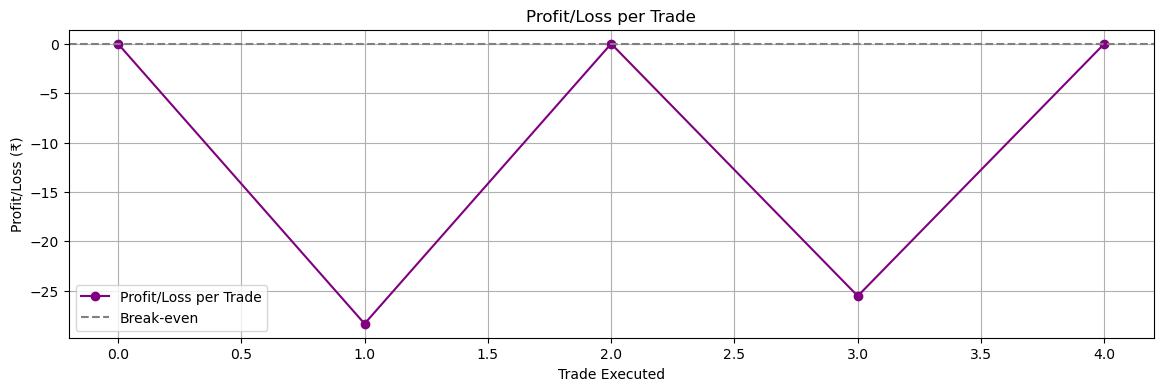

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Keltner Channel Calculation ---
ema_period = 20  # EMA period
atr_period = 14  # ATR period
atr_multiplier = 2  # Multiplier for ATR bands

# Calculate the Exponential Moving Average (EMA)
df["EMA"] = df["close"].ewm(span=ema_period, adjust=False).mean()

# Calculate True Range (TR)
df["High-Low"] = df["high"] - df["low"]
df["High-Close"] = abs(df["high"] - df["close"].shift(1))
df["Low-Close"] = abs(df["low"] - df["close"].shift(1))
df["TR"] = df[["High-Low", "High-Close", "Low-Close"]].max(axis=1)

# Calculate Average True Range (ATR)
df["ATR"] = df["TR"].rolling(window=atr_period).mean()

# Calculate Keltner Channel Bands
df["Upper_Band"] = df["EMA"] + (atr_multiplier * df["ATR"])
df["Lower_Band"] = df["EMA"] - (atr_multiplier * df["ATR"])

# --- Generate Buy and Sell Signals ---
df["Buy_Signal"] = df["close"] > df["Upper_Band"]  # Buy when price breaks above the upper band
df["Sell_Signal"] = df["close"] < df["Lower_Band"]  # Sell when price drops below the lower band

# Track Profits and Losses with Transaction Costs
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    curr_idx = df.index[i]

    # Buy Signal: Enter Long Trade
    if df.loc[curr_idx, "Buy_Signal"] and position != "Buy":
        position = "Buy"
        entry_price = df.loc[curr_idx, "close"]
        trade_log.append({"Date": curr_idx, "Action": "Buy", "Price": entry_price, "Profit": 0})

    # Sell Signal: Enter Short Trade or Exit Long
    elif df.loc[curr_idx, "Sell_Signal"] and position == "Buy":
        sell_price = df.loc[curr_idx, "close"]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            "Date": curr_idx,
            "Action": "Sell",
            "Price": sell_price,
            "Profit": final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# --- Plot Keltner Channel with Buy/Sell Signals ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="Close Price", alpha=0.7, color="blue")
plt.plot(df.index, df["EMA"], label="EMA", linestyle="--", color="black")
plt.plot(df.index, df["Upper_Band"], label="Upper Band", linestyle="--", color="red")
plt.plot(df.index, df["Lower_Band"], label="Lower Band", linestyle="--", color="green")

# Highlight Buy and Sell signals
buy_signals = df[df["Buy_Signal"]]
sell_signals = df[df["Sell_Signal"]]
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title("Keltner Channel Strategy")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# --- Plot Profit/Loss per Trade ---
plt.figure(figsize=(14, 4))
plt.plot([trade["Profit"] for trade in trade_log], label="Profit/Loss per Trade", color="purple", linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Price Action

Initial Balance: ₹10000
Final Balance: ₹10000.00
Total Profit/Loss: ₹0.00

Trade Log:
Empty DataFrame
Columns: []
Index: []


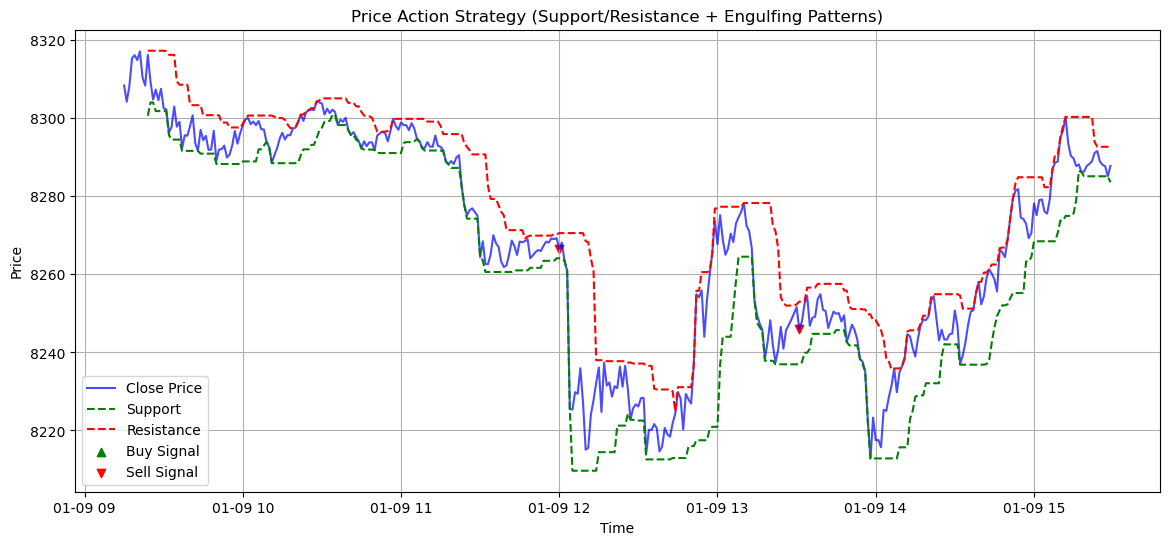

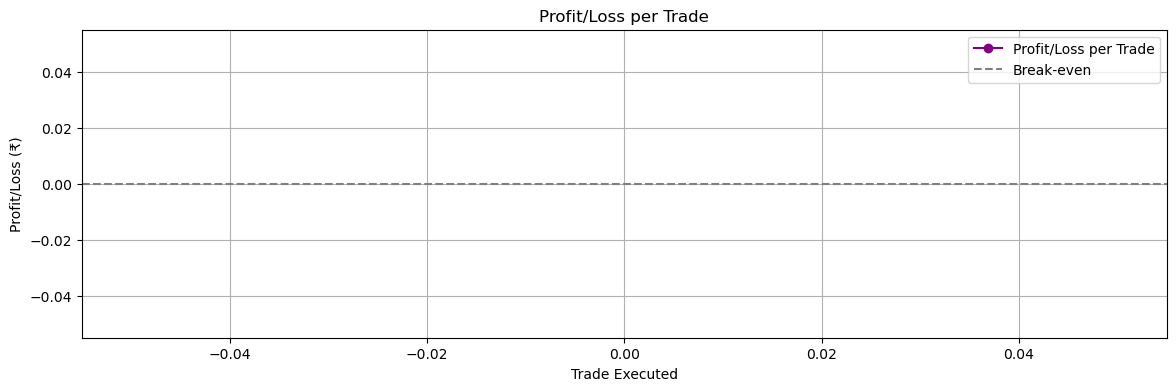

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming the data is in 1-minute intervals for one day)
df = pd.read_excel("one.xlsx", parse_dates=["date"])

# Ensure data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index (for better time-based indexing)
df.set_index("date", inplace=True)

# --- Identify Support and Resistance Levels ---
df["Support"] = df["low"].rolling(window=10).min()
df["Resistance"] = df["high"].rolling(window=10).max()

# --- Detect Price Action Patterns (Engulfing) ---
df["Bullish_Engulfing"] = (df["close"].shift(1) < df["open"].shift(1)) & (df["close"] > df["open"]) & (df["close"] > df["open"].shift(1)) & (df["open"] < df["close"].shift(1))
df["Bearish_Engulfing"] = (df["close"].shift(1) > df["open"].shift(1)) & (df["close"] < df["open"]) & (df["close"] < df["open"].shift(1)) & (df["open"] > df["close"].shift(1))

# --- Buy and Sell Signals ---
df["Buy_Signal"] = (df["low"] <= df["Support"]) & (df["Bullish_Engulfing"])
df["Sell_Signal"] = (df["high"] >= df["Resistance"]) & (df["Bearish_Engulfing"])

# --- Track Profits and Losses ---
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    curr_idx = df.index[i]

    # Buy Signal: Enter Long Trade
    if df.loc[curr_idx, "Buy_Signal"] and position != "Buy":
        position = "Buy"
        entry_price = df.loc[curr_idx, "close"]
        trade_log.append({"Date": curr_idx, "Action": "Buy", "Price": entry_price, "Profit": 0})

    # Sell Signal: Enter Short Trade or Exit Long
    elif df.loc[curr_idx, "Sell_Signal"] and position == "Buy":
        sell_price = df.loc[curr_idx, "close"]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            "Date": curr_idx,
            "Action": "Sell",
            "Price": sell_price,
            "Profit": final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# --- Plot Support, Resistance, and Buy/Sell Signals ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="Close Price", alpha=0.7, color="blue")
plt.plot(df.index, df["Support"], label="Support", linestyle="--", color="green")
plt.plot(df.index, df["Resistance"], label="Resistance", linestyle="--", color="red")

# Highlight Buy and Sell signals
buy_signals = df[df["Buy_Signal"]]
sell_signals = df[df["Sell_Signal"]]
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title("Price Action Strategy (Support/Resistance + Engulfing Patterns)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# --- Plot Profit/Loss per Trade ---
plt.figure(figsize=(14, 4))
plt.plot([trade["Profit"] for trade in trade_log], label="Profit/Loss per Trade", color="purple", linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()

In [ ]:
Gap Up/Gap Down

Initial Balance: ₹10000
Final Balance: ₹20957.95
Total Profit/Loss: ₹10957.95

Trade Log:
                   Date Action     Price       Profit
0   2015-01-15 09:15:00    Buy   8442.15     0.000000
1   2015-02-09 09:15:00   Sell   8553.65    92.984613
2   2015-04-23 09:15:00    Buy   8514.80     0.000000
3   2015-05-27 09:15:00   Sell   8360.95  -172.258414
4   2015-08-25 09:15:00    Buy   8054.05     0.000000
..                  ...    ...       ...          ...
108 2023-11-02 09:15:00    Buy  19089.75     0.000000
109 2024-02-14 09:15:00   Sell  21987.45  2853.186645
110 2024-03-21 09:15:00    Buy  22489.70     0.000000
111 2024-04-19 09:15:00   Sell  22541.20     2.420954
112 2024-08-06 09:15:00    Buy  25388.80     0.000000

[113 rows x 4 columns]


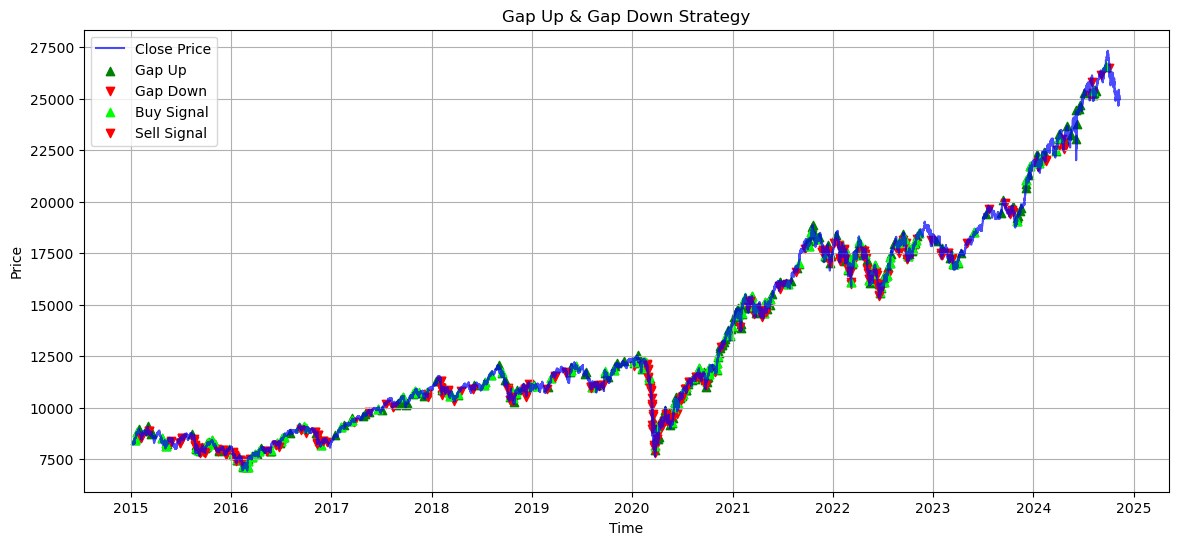

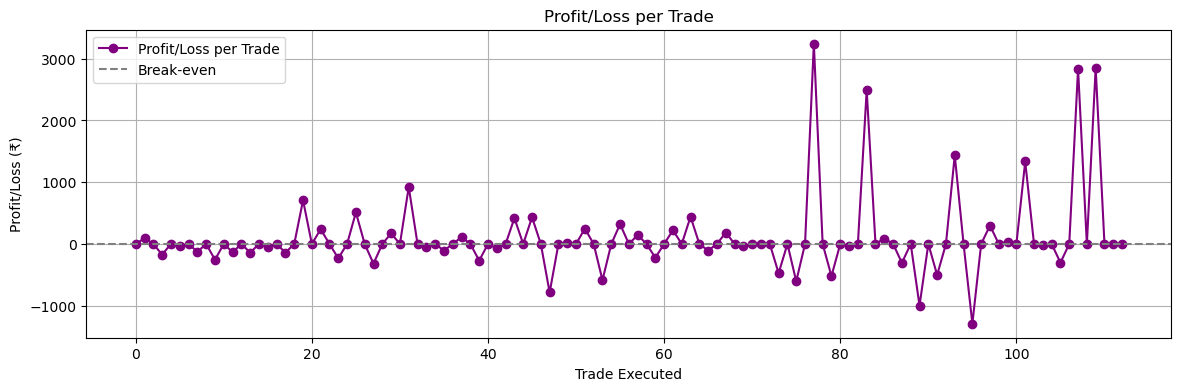

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming 1-minute intraday data)
df = pd.read_csv("one.csv", parse_dates=["date"])

# Ensure data is sorted by date
df = df.sort_values(by="date").reset_index(drop=True)

# Set date column as index
df.set_index("date", inplace=True)

# --- Identify Gap Up and Gap Down ---
df["Prev_Close"] = df["close"].shift(1)  # Previous day's close
df["Gap_Up"] = df["open"] > df["Prev_Close"] * 1.005  # Gap Up > 0.5%
df["Gap_Down"] = df["open"] < df["Prev_Close"] * 0.995  # Gap Down > 0.5%

# --- Buy & Sell Signals ---
df["Buy_Signal"] = df["Gap_Up"] & (df["close"] > df["open"])  # Buy if price stays above open
df["Sell_Signal"] = df["Gap_Down"] & (df["close"] < df["open"])  # Sell if price stays below open

# --- Track Profits and Losses ---
initial_balance = 10000  # Starting capital
balance = initial_balance
trade_log = []
position = None
entry_price = None

# Define transaction charges and taxes
brokerage_rate = 0.001  # 0.1% brokerage charge
gst_rate = 0.18  # GST on brokerage (18%)
stt_rate = 0.001  # 0.1% Securities Transaction Tax (STT)

for i in range(1, len(df)):
    curr_idx = df.index[i]

    # Buy Signal: Enter Long Trade
    if df.loc[curr_idx, "Buy_Signal"] and position != "Buy":
        position = "Buy"
        entry_price = df.loc[curr_idx, "close"]
        trade_log.append({"Date": curr_idx, "Action": "Buy", "Price": entry_price, "Profit": 0})

    # Sell Signal: Enter Short Trade or Exit Long
    elif df.loc[curr_idx, "Sell_Signal"] and position == "Buy":
        sell_price = df.loc[curr_idx, "close"]
        profit = sell_price - entry_price  # Profit or loss calculation

        # Calculate Transaction Costs
        brokerage = entry_price * brokerage_rate
        gst = brokerage * gst_rate
        stt = sell_price * stt_rate

        # Total transaction cost
        total_cost = brokerage + gst + stt

        # Final Profit or Loss after deducting charges
        final_profit_loss = profit - total_cost
        balance += final_profit_loss

        trade_log.append({
            "Date": curr_idx,
            "Action": "Sell",
            "Price": sell_price,
            "Profit": final_profit_loss
        })

        position = None  # Reset position after the trade

# Convert trade log to DataFrame for review
trade_df = pd.DataFrame(trade_log)

# Replace NaN values with 0
trade_df = trade_df.fillna(0)

# Final Balance & Profit Calculation
final_balance = balance
profit_loss = final_balance - initial_balance

# Print Results
print(f"Initial Balance: ₹{initial_balance}")
print(f"Final Balance: ₹{final_balance:.2f}")
print(f"Total Profit/Loss: ₹{profit_loss:.2f}")

# Display the trade log in tabular format
print("\nTrade Log:")
print(trade_df)

# --- Plot Gap Up & Gap Down with Buy/Sell Signals ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="Close Price", alpha=0.7, color="blue")

# Highlight Gap Up and Gap Down
plt.scatter(df[df["Gap_Up"]].index, df[df["Gap_Up"]]["open"], marker="^", color="green", label="Gap Up", alpha=1)
plt.scatter(df[df["Gap_Down"]].index, df[df["Gap_Down"]]["open"], marker="v", color="red", label="Gap Down", alpha=1)

# Highlight Buy and Sell signals
buy_signals = df[df["Buy_Signal"]]
sell_signals = df[df["Sell_Signal"]]
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="lime", label="Buy Signal", alpha=1)
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title("Gap Up & Gap Down Strategy")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# --- Plot Profit/Loss per Trade ---
plt.figure(figsize=(14, 4))
plt.plot([trade["Profit"] for trade in trade_log], label="Profit/Loss per Trade", color="purple", linestyle="-", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="Break-even")
plt.legend()
plt.title("Profit/Loss per Trade")
plt.xlabel("Trade Executed")
plt.ylabel("Profit/Loss (₹)")
plt.grid(True)
plt.show()